**Import libraries and select file**

In [120]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.spatial.transform import Rotation as R
from scipy.signal import find_peaks, peak_prominences

# read the csv file
dir = 'Data/'
name = '25-L'
registration = 'data.csv'
snapshot = 'snapshot.csv'

df = pd.read_csv(os.path.join(dir, name+registration))
df_snapshot = pd.read_csv(os.path.join(dir, name+snapshot))

Interpolate

In [121]:
def interpolate_quaternions(df):

    # Extract the necessary columns
    timestamps = df['Time'].values
    quaternions_s1 = df[['w1', 'x1', 'y1', 'z1']].values
    quaternions_s2 = df[['w2', 'x2', 'y2', 'z2']].values

    # Interpolate timestamps
    interpolated_timestamps = np.linspace(timestamps[0], timestamps[-1], len(timestamps) * 2)

    # Interpolate quaternions
    interpolated_quaternions_s1 = np.zeros((len(interpolated_timestamps), 4))
    for i in range(4):
        interpolated_quaternions_s1[:, i] = np.interp(interpolated_timestamps, timestamps, quaternions_s1[:, i])

    interpolated_quaternions_s2 = np.zeros((len(interpolated_timestamps), 4))
    for i in range(4):
        interpolated_quaternions_s2[:, i] = np.interp(interpolated_timestamps, timestamps, quaternions_s2[:, i])

    # Combine timestamps and quaternions
    interpolated_data = np.column_stack((interpolated_timestamps, interpolated_quaternions_s1, interpolated_quaternions_s2))

    return interpolated_data

# Assuming your CSV file is called 'data.csv'
interpolated_data = interpolate_quaternions(df)

df = pd.DataFrame(interpolated_data, columns=['Time', 'w1', 'x1', 'y1', 'z1', 'w2', 'x2', 'y2', 'z2'])



**Convert Quaternions to Euler Angles**

In [122]:
quat_data = []
Plot_euler_sensor_1 = []
Plot_euler_sensor_2 = []
Diff_plot = []
Diff_plot_inv = []
timing = []
euler_sequence = 'xyz'

def quaternion_to_euler1(q1):
    r = R.from_quat(q1)
    return r.as_euler(euler_sequence, degrees=True)

def quaternion_to_euler2(q2):
    r = R.from_quat(q2)
    return r.as_euler(euler_sequence, degrees=True)

def calculate_angular_difference(q1, q2):
    r1 = R.from_quat(q1)
    r2 = R.from_quat(q2)
    r = r2 * r1.inv()  
    return r.as_euler(euler_sequence, degrees=True)

def calculate_angular_difference_inv(q1, q2):
    r1 = R.from_quat(q1)
    r2 = R.from_quat(q2)
    r = r1 * r2.inv()  
    return r.as_euler(euler_sequence, degrees=True)

def interate_cvs(sequence):
    global euler_sequence, dataout_rows
    euler_sequence = sequence
    dataout_rows = []
    timestamp = 0

    for _, row in df.iterrows():
        w1 = float(row['w1'])
        x1 = float(row['x1'])
        y1 = float(row['y1'])
        z1 = float(row['z1'])
        w2 = float(row['w2'])
        x2 = float(row['x2'])
        y2 = float(row['y2'])
        z2 = float(row['z2'])
        q1 = w1, x1, y1, z1
        q2 = w2, x2, y2, z2

        Sensor1 = quaternion_to_euler1(q1)
        Sensor2 = quaternion_to_euler2(q2)
        diff = calculate_angular_difference(q1, q2)
        diff_inv = calculate_angular_difference_inv(q1, q2)
        timestamp += 1
        dataout_row = {
            'timestamp': timestamp,
            'Sensor1_x': Sensor1[0],
            'Sensor1_y': Sensor1[1],
            'Sensor1_z': Sensor1[2],
            'Sensor2_x': Sensor2[0],
            'Sensor2_y': Sensor2[1],
            'Sensor2_z': Sensor2[2],
            'Diff_x': diff[0],
            'Diff_y': diff[1],
            'Diff_z': diff[2],
            'Diff_inv_x': diff_inv[0],
            'Diff_inv_y': diff_inv[1],
            'Diff_inv_z': diff_inv[2]
        }
        dataout_rows.append(dataout_row)

interate_cvs('xyz')

# Create a new DataFrame from the list
converted_data = pd.DataFrame(dataout_rows)

def interate_snapshot_cvs(sequence):
    global euler_sequence, snapshot_rows
    euler_sequence = sequence
    snapshot_rows = []
    timestamp = 0

    for _, row in df_snapshot.iterrows():
        w1 = float(row['w1'])
        x1 = float(row['x1'])
        y1 = float(row['y1'])
        z1 = float(row['z1'])
        w2 = float(row['w2'])
        x2 = float(row['x2'])
        y2 = float(row['y2'])
        z2 = float(row['z2'])
        q1 = w1, x1, y1, z1
        q2 = w2, x2, y2, z2

        Sensor1 = quaternion_to_euler1(q1)
        Sensor2 = quaternion_to_euler2(q2)
        diff = calculate_angular_difference(q1, q2)
        diff_inv = calculate_angular_difference_inv(q1, q2)
        timestamp += 1
        snapshot_row = {
            'timestamp': timestamp,
            'Sensor1_x': Sensor1[0],
            'Sensor1_y': Sensor1[1],
            'Sensor1_z': Sensor1[2],
            'Sensor2_x': Sensor2[0],
            'Sensor2_y': Sensor2[1],
            'Sensor2_z': Sensor2[2],
            'Diff_x': diff[0],
            'Diff_y': diff[1],
            'Diff_z': diff[2],
            'Diff_inv_x': diff_inv[0],
            'Diff_inv_y': diff_inv[1],
            'Diff_inv_z': diff_inv[2]
        }
        snapshot_rows.append(snapshot_row)

interate_snapshot_cvs('xyz')

# Create a new DataFrame from the list
converted_snapshot = pd.DataFrame(snapshot_rows)

# Create a copy of 'Diff_x' and rename it to 'Degrees_x'
converted_data['Degrees_x'] = converted_data['Diff_x'].copy()

**Adjust data for baseline (calibrate)**

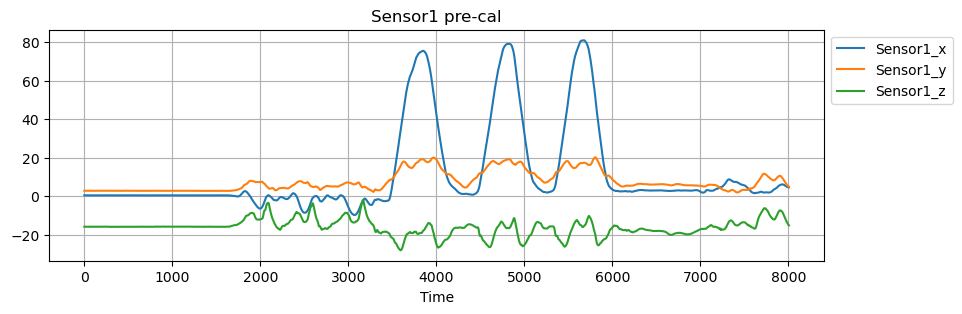

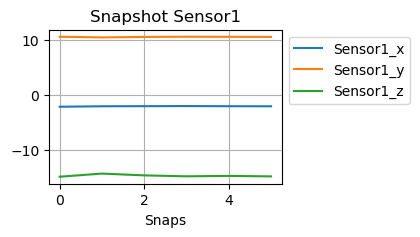

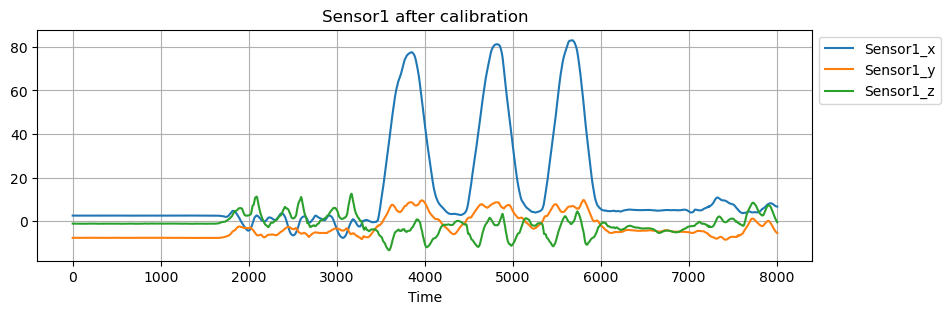

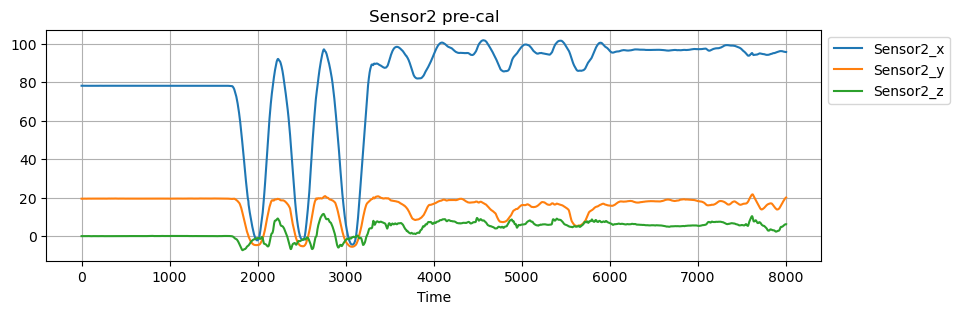

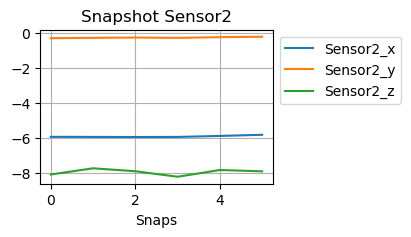

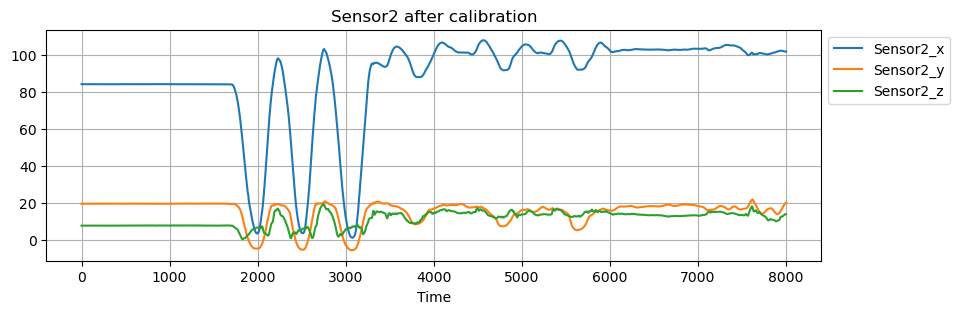

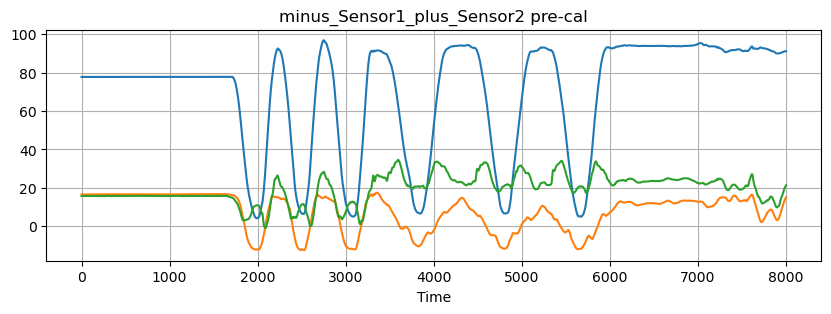

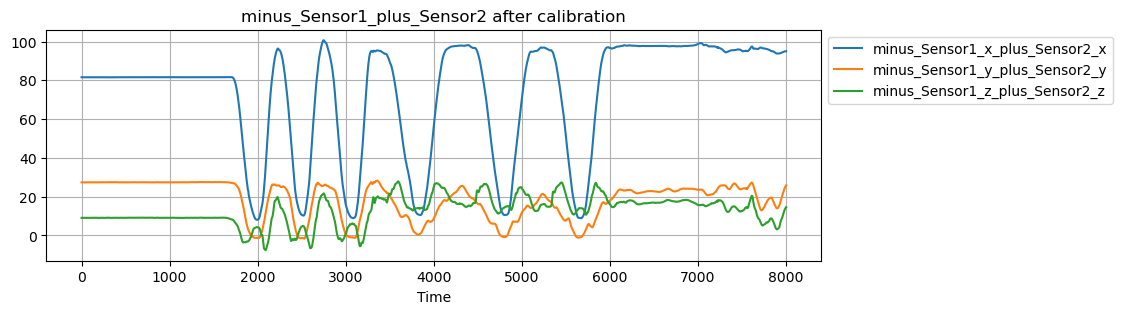

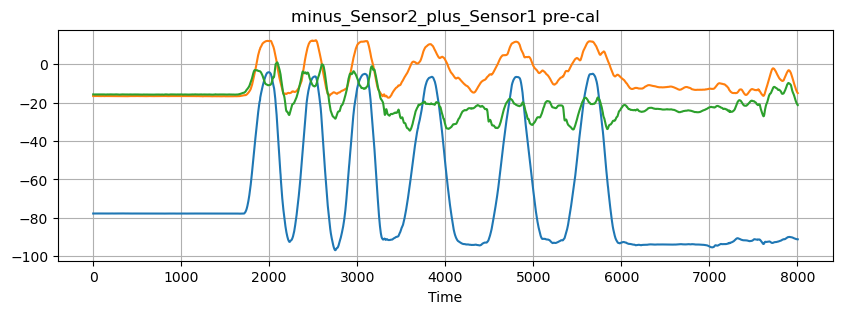

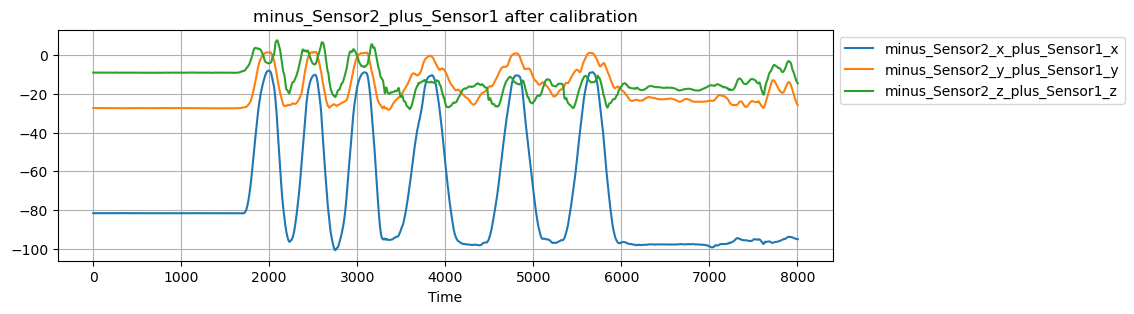

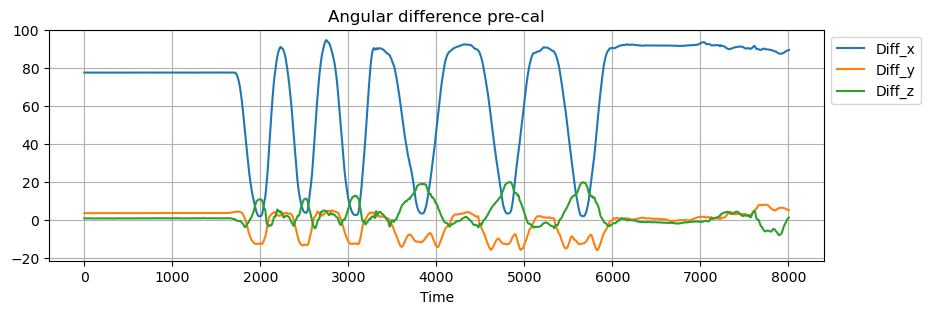

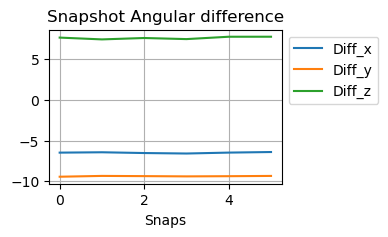

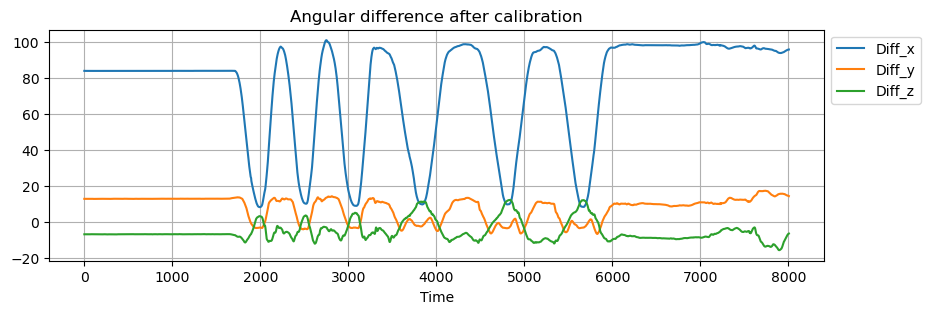

In [123]:
# calculate difference between the sensor 1 and sensor 2 before calibration
minus_Sensor1_x_plus_Sensor2_x_precal = - converted_data['Sensor1_x'] + converted_data['Sensor2_x']
minus_Sensor1_y_plus_Sensor2_y_precal = - converted_data['Sensor1_y'] + converted_data['Sensor2_y']
minus_Sensor1_z_plus_Sensor2_z_precal = - converted_data['Sensor1_z'] + converted_data['Sensor2_z']

minus_Sensor2_x_plus_Sensor1_x_precal = - converted_data['Sensor2_x'] + converted_data['Sensor1_x']
minus_Sensor2_y_plus_Sensor1_y_precal = - converted_data['Sensor2_y'] + converted_data['Sensor1_y']
minus_Sensor2_z_plus_Sensor1_z_precal = - converted_data['Sensor2_z'] + converted_data['Sensor1_z']

# calculate difference between the sensor 1 and sensor 2 for the snapshot
minus_Sensor1_x_plus_Sensor2_x_precal_snap = - converted_snapshot['Sensor1_x'] + converted_snapshot['Sensor2_x']
minus_Sensor1_y_plus_Sensor2_y_precal_snap = - converted_snapshot['Sensor1_y'] + converted_snapshot['Sensor2_y']
minus_Sensor1_z_plus_Sensor2_z_precal_snap = - converted_snapshot['Sensor1_z'] + converted_snapshot['Sensor2_z']

minus_Sensor2_x_plus_Sensor1_x_precal_snap = - converted_snapshot['Sensor2_x'] + converted_snapshot['Sensor1_x']
minus_Sensor2_y_plus_Sensor1_y_precal_snap = - converted_snapshot['Sensor2_y'] + converted_snapshot['Sensor1_y']
minus_Sensor2_z_plus_Sensor1_z_precal_snap = - converted_snapshot['Sensor2_z'] + converted_snapshot['Sensor1_z']

# Calculate the mean of all columns in snapshot
extension_baseline = converted_snapshot.mean()

converted_data_precal = converted_data.copy()

# Subtract the mean of snapshot from Diff_x, Diff_y, Diff_z and Degrees_x to calibrate the data
converted_data['Diff_x'] = converted_data['Diff_x'] - extension_baseline['Diff_x']
converted_data['Diff_y'] = converted_data['Diff_y'] - extension_baseline['Diff_y']
converted_data['Diff_z'] = converted_data['Diff_z'] - extension_baseline['Diff_z'] 
converted_data['Degrees_x'] = converted_data['Degrees_x'] - extension_baseline['Diff_x'] 

# Subtract the mean of snapshot from Sensor1_x, Sensor1_y, Sensor1_z, Sensor2_x, Sensor2_y, Sensor2_z
converted_data['Sensor1_x'] = converted_data['Sensor1_x'] - extension_baseline['Sensor1_x']
converted_data['Sensor1_y'] = converted_data['Sensor1_y'] - extension_baseline['Sensor1_y']
converted_data['Sensor1_z'] = converted_data['Sensor1_z'] - extension_baseline['Sensor1_z']
converted_data['Sensor2_x'] = converted_data['Sensor2_x'] - extension_baseline['Sensor2_x']
converted_data['Sensor2_y'] = converted_data['Sensor2_y'] - extension_baseline['Sensor2_y']
converted_data['Sensor2_z'] = converted_data['Sensor2_z'] - extension_baseline['Sensor2_z']

# calculate difference between the sensor 1 and sensor 2 after the calibration
minus_Sensor1_x_plus_Sensor2_x = - converted_data['Sensor1_x'] + converted_data['Sensor2_x']
minus_Sensor1_y_plus_Sensor2_y = - converted_data['Sensor1_y'] + converted_data['Sensor2_y']
minus_Sensor1_z_plus_Sensor2_z = - converted_data['Sensor1_z'] + converted_data['Sensor2_z']

minus_Sensor2_x_plus_Sensor1_x = - converted_data['Sensor2_x'] + converted_data['Sensor1_x']
minus_Sensor2_y_plus_Sensor1_y = - converted_data['Sensor2_y'] + converted_data['Sensor1_y']
minus_Sensor2_z_plus_Sensor1_z = - converted_data['Sensor2_z'] + converted_data['Sensor1_z']

# concat the difference to the converted_data
converted_data['minus_Sensor1_x_plus_Sensor2_x'] = minus_Sensor1_x_plus_Sensor2_x
converted_data['minus_Sensor1_y_plus_Sensor2_y'] = minus_Sensor1_y_plus_Sensor2_y
converted_data['minus_Sensor1_z_plus_Sensor2_z'] = minus_Sensor1_z_plus_Sensor2_z
converted_data['minus_Sensor2_x_plus_Sensor1_x'] = minus_Sensor2_x_plus_Sensor1_x
converted_data['minus_Sensor2_y_plus_Sensor1_y'] = minus_Sensor2_y_plus_Sensor1_y
converted_data['minus_Sensor2_z_plus_Sensor1_z'] = minus_Sensor2_z_plus_Sensor1_z

# calculate difference between the sensor 1 and sensor 2 for the snapshot
minus_Sensor1_x_plus_Sensor2_x_snap = - converted_snapshot['Sensor1_x'] + converted_snapshot['Sensor2_x']
minus_Sensor1_y_plus_Sensor2_y_snap = - converted_snapshot['Sensor1_y'] + converted_snapshot['Sensor2_y']
minus_Sensor1_z_plus_Sensor2_z_snap = - converted_snapshot['Sensor1_z'] + converted_snapshot['Sensor2_z']

minus_Sensor2_x_plus_Sensor1_x_snap = - converted_snapshot['Sensor2_x'] + converted_snapshot['Sensor1_x']
minus_Sensor2_y_plus_Sensor1_y_snap = - converted_snapshot['Sensor2_y'] + converted_snapshot['Sensor1_y']
minus_Sensor2_z_plus_Sensor1_z_snap = - converted_snapshot['Sensor2_z'] + converted_snapshot['Sensor1_z']

# concat the difference to the converted_snapshot
converted_snapshot['minus_Sensor1_x_plus_Sensor2_x'] = minus_Sensor1_x_plus_Sensor2_x_snap
converted_snapshot['minus_Sensor1_y_plus_Sensor2_y'] = minus_Sensor1_y_plus_Sensor2_y_snap
converted_snapshot['minus_Sensor1_z_plus_Sensor2_z'] = minus_Sensor1_z_plus_Sensor2_z_snap
converted_snapshot['minus_Sensor2_x_plus_Sensor1_x'] = minus_Sensor2_x_plus_Sensor1_x_snap
converted_snapshot['minus_Sensor2_y_plus_Sensor1_y'] = minus_Sensor2_y_plus_Sensor1_y_snap
converted_snapshot['minus_Sensor2_z_plus_Sensor1_z'] = minus_Sensor2_z_plus_Sensor1_z_snap

calibrated_data = converted_data

flexion_baseline = calibrated_data

# plot Sensor1 precal
plt.figure(figsize=(10, 3))
converted_data_precal['Sensor1_x'].plot()
converted_data_precal['Sensor1_y'].plot()
converted_data_precal['Sensor1_z'].plot()
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.grid()
plt.title('Sensor1 pre-cal')
plt.xlabel('Time')
plt.show()

# plot Sensor1 for the snapshot
plt.figure(figsize=(3, 2))
converted_snapshot['Sensor1_x'].plot()
converted_snapshot['Sensor1_y'].plot()
converted_snapshot['Sensor1_z'].plot()
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.grid()
plt.title('Snapshot Sensor1')
plt.xlabel('Snaps')
plt.show()

# plot Sensor1
plt.figure(figsize=(10, 3))
calibrated_data['Sensor1_x'].plot()
calibrated_data['Sensor1_y'].plot()
calibrated_data['Sensor1_z'].plot()
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.grid()
plt.title('Sensor1 after calibration')
plt.xlabel('Time')
plt.show()

# plot Sensor2 precal
plt.figure(figsize=(10, 3))
converted_data_precal['Sensor2_x'].plot()
converted_data_precal['Sensor2_y'].plot()
converted_data_precal['Sensor2_z'].plot()
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.grid()
plt.title('Sensor2 pre-cal')
plt.xlabel('Time')
plt.show()

# plot Sensor2 for the snapshot
plt.figure(figsize=(3, 2))
converted_snapshot['Sensor2_x'].plot()
converted_snapshot['Sensor2_y'].plot()
converted_snapshot['Sensor2_z'].plot()
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.grid()
plt.title('Snapshot Sensor2')
plt.xlabel('Snaps')
plt.show()

# plot Sensor2
plt.figure(figsize=(10, 3))
calibrated_data['Sensor2_x'].plot()
calibrated_data['Sensor2_y'].plot()
calibrated_data['Sensor2_z'].plot()
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.grid()
plt.title('Sensor2 after calibration')
plt.xlabel('Time')
plt.show()

# plot minus_Sensor1_plus_Sensor2 precal
plt.figure(figsize=(10, 3))
minus_Sensor1_x_plus_Sensor2_x_precal.plot()
minus_Sensor1_y_plus_Sensor2_y_precal.plot()
minus_Sensor1_z_plus_Sensor2_z_precal.plot()
plt.grid()
plt.title('minus_Sensor1_plus_Sensor2 pre-cal')
plt.xlabel('Time')
plt.show()

# plot minus_Sensor1_plus_Sensor2
plt.figure(figsize=(10, 3))
calibrated_data['minus_Sensor1_x_plus_Sensor2_x'].plot()
calibrated_data['minus_Sensor1_y_plus_Sensor2_y'].plot()
calibrated_data['minus_Sensor1_z_plus_Sensor2_z'].plot()
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.grid()
plt.title('minus_Sensor1_plus_Sensor2 after calibration')
plt.xlabel('Time')
plt.show()

# plot minus_Sensor2_plus_Sensor1 precal
plt.figure(figsize=(10, 3))
minus_Sensor2_x_plus_Sensor1_x_precal.plot()
minus_Sensor2_y_plus_Sensor1_y_precal.plot()
minus_Sensor2_z_plus_Sensor1_z_precal.plot()
plt.grid()
plt.title('minus_Sensor2_plus_Sensor1 pre-cal')
plt.xlabel('Time')
plt.show()

# plot minusSensor2_plus_Sensor1
plt.figure(figsize=(10, 3))
calibrated_data['minus_Sensor2_x_plus_Sensor1_x'].plot()
calibrated_data['minus_Sensor2_y_plus_Sensor1_y'].plot()
calibrated_data['minus_Sensor2_z_plus_Sensor1_z'].plot()
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.grid()
plt.title('minus_Sensor2_plus_Sensor1 after calibration')
plt.xlabel('Time')
plt.show()

# plot Angular difference (Diff_x, Diff_y, Diff_z)
plt.figure(figsize=(10, 3))
converted_data_precal['Diff_x'].plot()
converted_data_precal['Diff_y'].plot()
converted_data_precal['Diff_z'].plot()
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.grid()
plt.title('Angular difference pre-cal')
plt.xlabel('Time')
plt.show()

# plot Angular difference for the snapshot
plt.figure(figsize=(3, 2))
converted_snapshot['Diff_x'].plot()
converted_snapshot['Diff_y'].plot()
converted_snapshot['Diff_z'].plot()
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.grid()
plt.title('Snapshot Angular difference')
plt.xlabel('Snaps')
plt.show()

# plot 
plt.figure(figsize=(10, 3))
calibrated_data['Diff_x'].plot()
calibrated_data['Diff_y'].plot()
calibrated_data['Diff_z'].plot()
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.grid()
plt.title('Angular difference after calibration')
plt.xlabel('Time')
plt.show()


**Drop begin and end**

**Find Peaks and Valleys**

Check Graph!

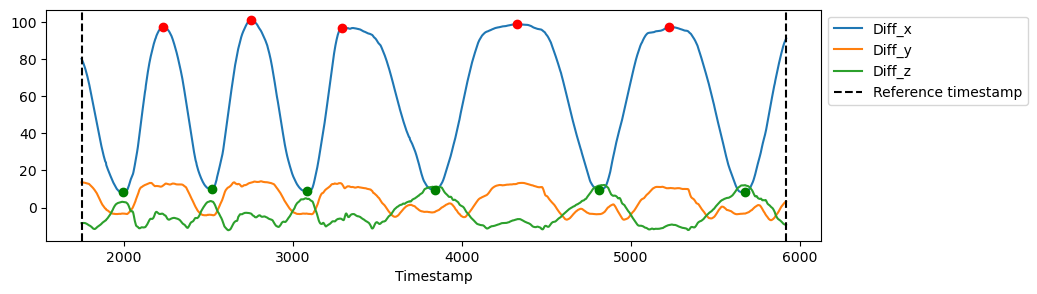

In [124]:
# Calculate the derivative of Diff_x
degrees_x_derivative = np.gradient(calibrated_data['Degrees_x'])

# Set a threshold for detecting rapid changes
threshold = 0.2  # You may need to adjust this threshold based on your data

# Find the indices where the derivative exceeds the threshold for the first time for both increase and decrease
rapid_increase_index = np.argmax(degrees_x_derivative > threshold)
rapid_decrease_index = np.argmax(degrees_x_derivative < -threshold)

# Get the timestamp at the rapid increase and decrease points
rapid_increase_timestamp = calibrated_data['timestamp'].iloc[rapid_increase_index]
rapid_decrease_timestamp = calibrated_data['timestamp'].iloc[rapid_decrease_index]

# Determine the reference timestamp
reference_timestamp = min(rapid_increase_timestamp, rapid_decrease_timestamp)

# Create a new DataFrame by filtering rows based on the reference timestamp
calibrated_data = calibrated_data[calibrated_data['timestamp'] >= reference_timestamp].copy()

# Reset index
calibrated_data.reset_index(drop=True, inplace=True)

# Calculate the derivative of Diff_x
degrees_x_derivative = np.gradient(calibrated_data['Degrees_x'])

# Reverse the DataFrame after filtering based on the initial rapid change point
dataout_reverse = calibrated_data[::-1].copy()

# Calculate the derivative of Diff_x for the reversed DataFrame
degrees_x_derivative_reverse = np.gradient(dataout_reverse['Degrees_x'])

# Find the index where the reversed derivative exceeds the threshold for the first time
rapid_change_index_reverse = np.argmax(np.abs(degrees_x_derivative_reverse) > threshold)

# Get the timestamp at the rapid change point from the end
rapid_change_timestamp_reverse = dataout_reverse['timestamp'].iloc[rapid_change_index_reverse]

# Drop rows after rapid_change_timestamp_reverse
calibrated_data = calibrated_data[calibrated_data['timestamp'] <= rapid_change_timestamp_reverse].copy()

# Reset index
calibrated_data.reset_index(drop=True, inplace=True)


dropped_calibrated_data = calibrated_data

# Find peaks
peaks, _ = find_peaks(dropped_calibrated_data['Degrees_x'], distance=20)  
# Find valleys
valleys, _ = find_peaks(-dropped_calibrated_data['Degrees_x'], distance=20) 
# Compute prominences of peaks
prominences_peaks = peak_prominences(dropped_calibrated_data['Degrees_x'], peaks)[0]
# Filter peaks based on prominence
filtered_peaks = peaks[prominences_peaks > 30]
# Compute prominences of valleys
prominences_valleys = peak_prominences(-dropped_calibrated_data['Degrees_x'], valleys)[0]
# Filter valleys based on prominence
filtered_valleys = valleys[prominences_valleys > 30]
# find timestamp of filtered peaks
filtered_peaks_timestamp = dropped_calibrated_data['timestamp'].iloc[filtered_peaks]
# find timestamp of filtered valleys
filtered_valleys_timestamp = dropped_calibrated_data['timestamp'].iloc[filtered_valleys]
# find Degrees_x of filtered peaks
filtered_peaks_degrees_x = dropped_calibrated_data['Degrees_x'].iloc[filtered_peaks]
# find Degrees_x of filtered valleys
filtered_valleys_degrees_x = dropped_calibrated_data['Degrees_x'].iloc[filtered_valleys]

# print("Filtered peaks:", filtered_peaks)
# print("Timestamp of filtered peaks:", filtered_peaks_timestamp)
# print("Filtered valleys:", filtered_valleys)
# print("Timestamp of filtered valleys:", filtered_valleys_timestamp)


# plot dataout 'Diff_x', 'Diff_y', 'Diff_z'
plt.figure(figsize=(10, 3))
plt.plot(dropped_calibrated_data['timestamp'], dropped_calibrated_data['Diff_x'], label='Diff_x')
plt.plot(dropped_calibrated_data['timestamp'], dropped_calibrated_data['Diff_y'], label='Diff_y')
plt.plot(dropped_calibrated_data['timestamp'], dropped_calibrated_data['Diff_z'], label='Diff_z')

# plot rapid change timestamps
plt.axvline(x=reference_timestamp, color='black', linestyle='--', label='Reference timestamp')
plt.axvline(x=rapid_change_timestamp_reverse, color='black', linestyle='--')

# plot filtered peaks
plt.plot(filtered_peaks_timestamp, dropped_calibrated_data['Diff_x'].iloc[filtered_peaks], "o", color='red')

# plot filtered valleys
plt.plot(filtered_valleys_timestamp, dropped_calibrated_data['Diff_x'].iloc[filtered_valleys], "o", color='green')

plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.xlabel('Timestamp')
plt.show()



**Determine which of the three OKC and CKC has the largest extension**

For **left** side look at **smallest** filtered **valleys**

For **right** side look at **largest** filtered **peaks**

In [125]:
print("Filtered peaks Degrees_x:", filtered_peaks_degrees_x)
print("Filtered valleys Degrees_x:", filtered_valleys_degrees_x)

Filtered peaks Degrees_x: 479      97.485858
1000    101.035810
1540     96.890909
2572     98.865849
3472     97.314943
Name: Degrees_x, dtype: float64
Filtered valleys Degrees_x: 243      8.139187
769     10.034016
1335     8.777643
2087     9.592367
3057     9.638127
3922     8.176661
Name: Degrees_x, dtype: float64


**Cut cycles and 'normalize' data to degrees instead of time**

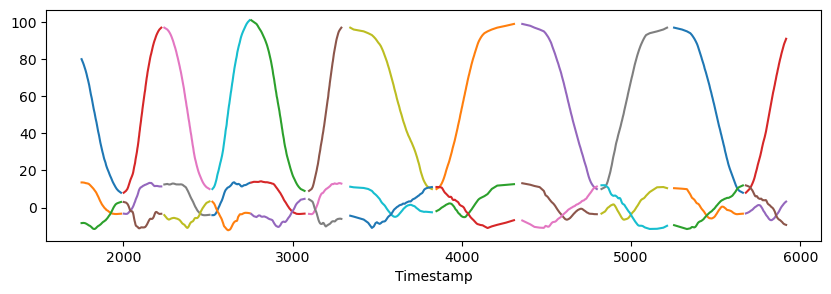

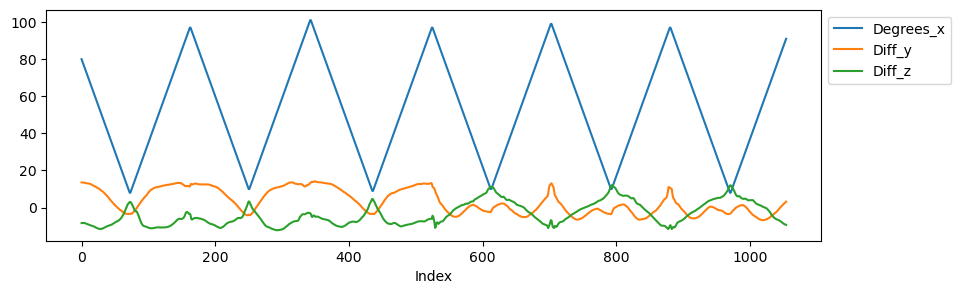

In [126]:
cut_dataframes = []

# Initialize start index as 0
start_index = 0

# Determine whether the data starts with a peak or a valley
if filtered_peaks[0] < filtered_valleys[0]:
    peak_first = True
else:
    peak_first = False

# Iterate through peaks and valleys
for peak_index, valley_index in zip(filtered_peaks, filtered_valleys):
    # Slice the dataframe from start_index to peak_index or valley_index depending on the peak_first condition
    if peak_first:
        first_cut = dropped_calibrated_data.iloc[start_index:peak_index+1].copy()
        cut_dataframes.append(first_cut)
    else:
        first_cut = dropped_calibrated_data.iloc[start_index:valley_index+1].copy()
        cut_dataframes.append(first_cut)
    
    # Slice the dataframe from peak_index to valley_index or valley_index to peak_index depending on the peak_first condition
    if peak_first:
        second_cut = dropped_calibrated_data.iloc[peak_index:valley_index+1].copy()
        cut_dataframes.append(second_cut)
    else:
        second_cut = dropped_calibrated_data.iloc[valley_index:peak_index+1].copy()
        cut_dataframes.append(second_cut)
    
    # Update start_index for the next iteration
    if peak_first:
        start_index = valley_index
    else:
        start_index = peak_index

if peak_first:
        # Check if there are remaining peaks after the last valley
    if filtered_peaks[-1] > filtered_valleys[-1]:
        # Include the remaining data from the last valley to the last peak
        last_valley_index = filtered_valleys[-1]
        last_peak_index = filtered_peaks[-1]
        last_cut = dropped_calibrated_data.iloc[last_valley_index:last_peak_index+1].copy()
        cut_dataframes.append(last_cut)

    # Include the data after the last peak if it's the case
    if last_peak_index < len(dropped_calibrated_data):
        remaining_data = dropped_calibrated_data.iloc[last_peak_index:].copy()
        cut_dataframes.append(remaining_data)

else:
    # Check if there are remaining valleys after the last peak
    if filtered_valleys[-1] > filtered_peaks[-1]:
        # Include the remaining data from the last peak to the last valley
        last_peak_index = filtered_peaks[-1]
        last_valley_index = filtered_valleys[-1]
        last_cut = dropped_calibrated_data.iloc[last_peak_index:last_valley_index+1].copy()
        cut_dataframes.append(last_cut)

    # Include the data after the last valley if it's the case
    if last_valley_index < len(dropped_calibrated_data):
        remaining_data = dropped_calibrated_data.iloc[last_valley_index:].copy()
        cut_dataframes.append(remaining_data)

# Loop through each dataframe in cut_dataframes
for df_cut in cut_dataframes:
    # Round the Diff_x values in each dataframe
    df_cut['Degrees_x'] = df_cut['Degrees_x'].round()
    df_cut['Diff_x'] = df_cut['Diff_x'].round()
    df_cut['Diff_inv_x'] = df_cut['Diff_inv_x'].round()


# Create a list to store the averaged dataframes
degree_averaged_dfs = []

# Loop through each dataframe in cut_dataframes
for df_cut in cut_dataframes:
    # Group by the 'Degrees_x' column and calculate the average for each group
    degree_averaged_df = df_cut.groupby('Degrees_x', sort=False).mean().reset_index()
    degree_averaged_dfs.append(degree_averaged_df)

plt.figure(figsize=(10, 3))
# Plot the averaged dataframes
for i, df_avg in enumerate(degree_averaged_dfs):
    plt.plot(df_avg['timestamp'], df_avg['Diff_x'], label=f"Averaged DataFrame {i+1}")
    plt.plot(df_avg['timestamp'], df_avg['Diff_y'], label=f"Averaged DataFrame {i+1}")
    plt.plot(df_avg['timestamp'], df_avg['Diff_z'], label=f"Averaged DataFrame {i+1}")

# plt.figure(figsize=(10, 3))
# for i, df_avg in enumerate(degree_averaged_dfs):
#     plt.plot(df_avg['timestamp'], df_avg['minus_Sensor1_x_plus_Sensor2_x'], label=f"Averaged DataFrame {i+1}")
#     plt.plot(df_avg['timestamp'], df_avg['minus_Sensor1_y_plus_Sensor2_y'], label=f"Averaged DataFrame {i+1}")
#     plt.plot(df_avg['timestamp'], df_avg['minus_Sensor1_z_plus_Sensor2_z'], label=f"Averaged DataFrame {i+1}")

# plt.figure(figsize=(10, 3))
# for i, df_avg in enumerate(degree_averaged_dfs):
#     plt.plot(df_avg['timestamp'], df_avg['minus_Sensor2_x_plus_Sensor1_x'], label=f"Averaged DataFrame {i+1}")
#     plt.plot(df_avg['timestamp'], df_avg['minus_Sensor2_y_plus_Sensor1_y'], label=f"Averaged DataFrame {i+1}")
#     plt.plot(df_avg['timestamp'], df_avg['minus_Sensor2_z_plus_Sensor1_z'], label=f"Averaged DataFrame {i+1}")

plt.xlabel('Timestamp')
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Concatenate the averaged dataframes
degree_data = pd.concat(degree_averaged_dfs, ignore_index=True)

# Plot the concatenated averaged dataframes
plt.figure(figsize=(10, 3))
plt.plot(degree_data.index, degree_data['Degrees_x'], label='Degrees_x')
plt.plot(degree_data.index, degree_data['Diff_y'], label='Diff_y')
plt.plot(degree_data.index, degree_data['Diff_z'], label='Diff_z')
plt.xlabel('Index')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

# plt.figure(figsize=(10, 3))
# plt.plot(degree_data.index, degree_data['minus_Sensor2_x_plus_Sensor1_x'], label='minus_Sensor2_x_plus_Sensor1_x')
# plt.plot(degree_data.index, degree_data['minus_Sensor2_y_plus_Sensor1_y'], label='minus_Sensor2_y_plus_Sensor1_y')
# plt.plot(degree_data.index, degree_data['minus_Sensor2_z_plus_Sensor1_z'], label='minus_Sensor2_z_plus_Sensor1_z')
# plt.xlabel('Index')
# plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
# plt.show()


**Calculate average cycle for the 3 Open and Closed Kinetic Chain cycles**

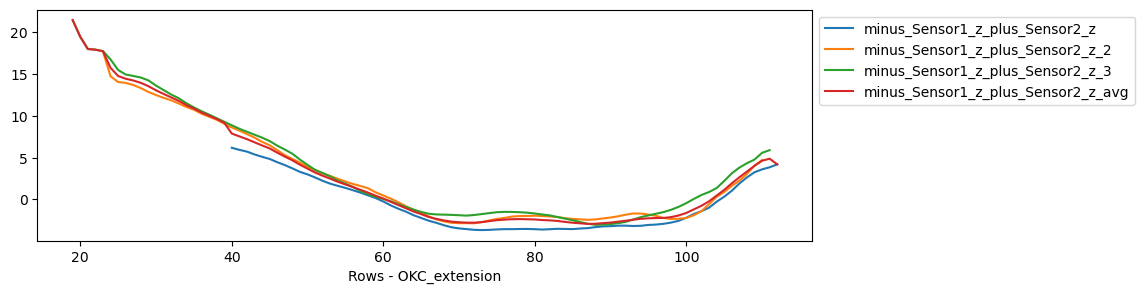

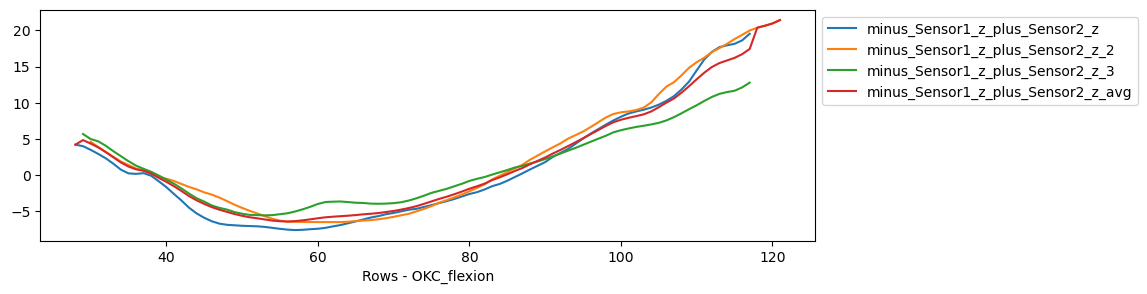

In [127]:
# Define the range for extention
if peak_first:
    extension_range = np.arange(-120, 21)
else:
    extension_range = np.arange(120, -21, -1)
    

columns = ['Degrees_x']
# Create an empty dataframe with the specified index and columns
extension_df = pd.DataFrame(index=extension_range, columns=columns)

extension_df['Degrees_x'] = extension_df.index


# Define the range for flexion

if peak_first:
    flexion_range = np.arange(20, -121, -1)  #generate the range in descending order
else:
    flexion_range = np.arange(-20, 121)

columns = ['Degrees_x']
# Create an empty dataframe with the specified index and columns
flexion_df = pd.DataFrame(index=flexion_range, columns=columns)

flexion_df['Degrees_x'] = flexion_df.index

OKC_extension_df = pd.merge(extension_df, degree_averaged_dfs[0], on='Degrees_x', how='left')
OKC_extension_df = pd.merge(OKC_extension_df, degree_averaged_dfs[2], on='Degrees_x', how='left', suffixes=('', '_2'))
OKC_extension_df = pd.merge(OKC_extension_df, degree_averaged_dfs[4], on='Degrees_x', how='left', suffixes=('', '_3'))

OKC_flexion_df = pd.merge(flexion_df, degree_averaged_dfs[1], on='Degrees_x', how='left')
OKC_flexion_df = pd.merge(OKC_flexion_df, degree_averaged_dfs[3], on='Degrees_x', how='left', suffixes=('', '_2'))
OKC_flexion_df = pd.merge(OKC_flexion_df, degree_averaged_dfs[5], on='Degrees_x', how='left', suffixes=('', '_3'))

CKC_extension_df = pd.merge(extension_df, degree_averaged_dfs[6], on='Degrees_x', how='left')
CKC_extension_df = pd.merge(CKC_extension_df, degree_averaged_dfs[8], on='Degrees_x', how='left', suffixes=('', '_2'))
CKC_extension_df = pd.merge(CKC_extension_df, degree_averaged_dfs[10], on='Degrees_x', how='left', suffixes=('', '_3'))

CKC_flexion_df = pd.merge(flexion_df, degree_averaged_dfs[7], on='Degrees_x', how='left')
CKC_flexion_df = pd.merge(CKC_flexion_df, degree_averaged_dfs[9], on='Degrees_x', how='left', suffixes=('', '_2'))
CKC_flexion_df = pd.merge(CKC_flexion_df, degree_averaged_dfs[11], on='Degrees_x', how='left', suffixes=('', '_3'))


# Calculate the average
OKC_extension_df['timestamp_avg'] = OKC_extension_df[['timestamp', 'timestamp_2', 'timestamp_3']].mean(axis=1)
OKC_extension_df['Sensor1_x_avg'] = OKC_extension_df[['Sensor1_x', 'Sensor1_x_2', 'Sensor1_x_3']].mean(axis=1)
OKC_extension_df['Sensor1_y_avg'] = OKC_extension_df[['Sensor1_y', 'Sensor1_y_2', 'Sensor1_y_3']].mean(axis=1)
OKC_extension_df['Sensor1_z_avg'] = OKC_extension_df[['Sensor1_z', 'Sensor1_z_2', 'Sensor1_z_3']].mean(axis=1)
OKC_extension_df['Sensor2_x_avg'] = OKC_extension_df[['Sensor2_x', 'Sensor2_x_2', 'Sensor2_x_3']].mean(axis=1)
OKC_extension_df['Sensor2_y_avg'] = OKC_extension_df[['Sensor2_y', 'Sensor2_y_2', 'Sensor2_y_3']].mean(axis=1)
OKC_extension_df['Sensor2_z_avg'] = OKC_extension_df[['Sensor2_z', 'Sensor2_z_2', 'Sensor2_z_3']].mean(axis=1)
OKC_extension_df['Diff_x_avg'] = OKC_extension_df[['Diff_x', 'Diff_x_2', 'Diff_x_3']].mean(axis=1)
OKC_extension_df['Diff_y_avg'] = OKC_extension_df[['Diff_y', 'Diff_y_2', 'Diff_y_3']].mean(axis=1)
OKC_extension_df['Diff_z_avg'] = OKC_extension_df[['Diff_z', 'Diff_z_2', 'Diff_z_3']].mean(axis=1)
OKC_extension_df['Diff_inv_x_avg'] = OKC_extension_df[['Diff_inv_x', 'Diff_inv_x_2', 'Diff_inv_x_3']].mean(axis=1)
OKC_extension_df['Diff_inv_y_avg'] = OKC_extension_df[['Diff_inv_y', 'Diff_inv_y_2', 'Diff_inv_y_3']].mean(axis=1)
OKC_extension_df['Diff_inv_z_avg'] = OKC_extension_df[['Diff_inv_z', 'Diff_inv_z_2', 'Diff_inv_z_3']].mean(axis=1)
OKC_extension_df['minus_Sensor1_x_plus_Sensor2_x_avg'] = OKC_extension_df[['minus_Sensor1_x_plus_Sensor2_x', 'minus_Sensor1_x_plus_Sensor2_x_2', 'minus_Sensor1_x_plus_Sensor2_x_3']].mean(axis=1)
OKC_extension_df['minus_Sensor1_y_plus_Sensor2_y_avg'] = OKC_extension_df[['minus_Sensor1_y_plus_Sensor2_y', 'minus_Sensor1_y_plus_Sensor2_y_2', 'minus_Sensor1_y_plus_Sensor2_y_3']].mean(axis=1)
OKC_extension_df['minus_Sensor1_z_plus_Sensor2_z_avg'] = OKC_extension_df[['minus_Sensor1_z_plus_Sensor2_z', 'minus_Sensor1_z_plus_Sensor2_z_2', 'minus_Sensor1_z_plus_Sensor2_z_3']].mean(axis=1)
OKC_extension_df['minus_Sensor2_x_plus_Sensor1_x_avg'] = OKC_extension_df[['minus_Sensor2_x_plus_Sensor1_x', 'minus_Sensor2_x_plus_Sensor1_x_2', 'minus_Sensor2_x_plus_Sensor1_x_3']].mean(axis=1)
OKC_extension_df['minus_Sensor2_y_plus_Sensor1_y_avg'] = OKC_extension_df[['minus_Sensor2_y_plus_Sensor1_y', 'minus_Sensor2_y_plus_Sensor1_y_2', 'minus_Sensor2_y_plus_Sensor1_y_3']].mean(axis=1)
OKC_extension_df['minus_Sensor2_z_plus_Sensor1_z_avg'] = OKC_extension_df[['minus_Sensor2_z_plus_Sensor1_z', 'minus_Sensor2_z_plus_Sensor1_z_2', 'minus_Sensor2_z_plus_Sensor1_z_3']].mean(axis=1)

# Write OKC_extension_df to a CSV file
OKC_extension_df.to_csv('OKC_extension.csv', index=False)


OKC_flexion_df['timestamp_avg'] = OKC_flexion_df[['timestamp', 'timestamp_2', 'timestamp_3']].mean(axis=1)
OKC_flexion_df['Sensor1_x_avg'] = OKC_flexion_df[['Sensor1_x', 'Sensor1_x_2', 'Sensor1_x_3']].mean(axis=1)
OKC_flexion_df['Sensor1_y_avg'] = OKC_flexion_df[['Sensor1_y', 'Sensor1_y_2', 'Sensor1_y_3']].mean(axis=1)
OKC_flexion_df['Sensor1_z_avg'] = OKC_flexion_df[['Sensor1_z', 'Sensor1_z_2', 'Sensor1_z_3']].mean(axis=1)
OKC_flexion_df['Sensor2_x_avg'] = OKC_flexion_df[['Sensor2_x', 'Sensor2_x_2', 'Sensor2_x_3']].mean(axis=1)
OKC_flexion_df['Sensor2_y_avg'] = OKC_flexion_df[['Sensor2_y', 'Sensor2_y_2', 'Sensor2_y_3']].mean(axis=1)
OKC_flexion_df['Sensor2_z_avg'] = OKC_flexion_df[['Sensor2_z', 'Sensor2_z_2', 'Sensor2_z_3']].mean(axis=1)
OKC_flexion_df['Diff_x_avg'] = OKC_flexion_df[['Diff_x', 'Diff_x_2', 'Diff_x_3']].mean(axis=1)
OKC_flexion_df['Diff_y_avg'] = OKC_flexion_df[['Diff_y', 'Diff_y_2', 'Diff_y_3']].mean(axis=1)
OKC_flexion_df['Diff_z_avg'] = OKC_flexion_df[['Diff_z', 'Diff_z_2', 'Diff_z_3']].mean(axis=1)
OKC_flexion_df['Diff_inv_x_avg'] = OKC_flexion_df[['Diff_inv_x', 'Diff_inv_x_2', 'Diff_inv_x_3']].mean(axis=1)
OKC_flexion_df['Diff_inv_y_avg'] = OKC_flexion_df[['Diff_inv_y', 'Diff_inv_y_2', 'Diff_inv_y_3']].mean(axis=1)
OKC_flexion_df['Diff_inv_z_avg'] = OKC_flexion_df[['Diff_inv_z', 'Diff_inv_z_2', 'Diff_inv_z_3']].mean(axis=1)
OKC_flexion_df['minus_Sensor1_x_plus_Sensor2_x_avg'] = OKC_flexion_df[['minus_Sensor1_x_plus_Sensor2_x', 'minus_Sensor1_x_plus_Sensor2_x_2', 'minus_Sensor1_x_plus_Sensor2_x_3']].mean(axis=1)
OKC_flexion_df['minus_Sensor1_y_plus_Sensor2_y_avg'] = OKC_flexion_df[['minus_Sensor1_y_plus_Sensor2_y', 'minus_Sensor1_y_plus_Sensor2_y_2', 'minus_Sensor1_y_plus_Sensor2_y_3']].mean(axis=1)
OKC_flexion_df['minus_Sensor1_z_plus_Sensor2_z_avg'] = OKC_flexion_df[['minus_Sensor1_z_plus_Sensor2_z', 'minus_Sensor1_z_plus_Sensor2_z_2', 'minus_Sensor1_z_plus_Sensor2_z_3']].mean(axis=1)
OKC_flexion_df['minus_Sensor2_x_plus_Sensor1_x_avg'] = OKC_flexion_df[['minus_Sensor2_x_plus_Sensor1_x', 'minus_Sensor2_x_plus_Sensor1_x_2', 'minus_Sensor2_x_plus_Sensor1_x_3']].mean(axis=1)
OKC_flexion_df['minus_Sensor2_y_plus_Sensor1_y_avg'] = OKC_flexion_df[['minus_Sensor2_y_plus_Sensor1_y', 'minus_Sensor2_y_plus_Sensor1_y_2', 'minus_Sensor2_y_plus_Sensor1_y_3']].mean(axis=1)
OKC_flexion_df['minus_Sensor2_z_plus_Sensor1_z_avg'] = OKC_flexion_df[['minus_Sensor2_z_plus_Sensor1_z', 'minus_Sensor2_z_plus_Sensor1_z_2', 'minus_Sensor2_z_plus_Sensor1_z_3']].mean(axis=1)

CKC_extension_df['timestamp_avg'] = CKC_extension_df[['timestamp', 'timestamp_2', 'timestamp_3']].mean(axis=1)
CKC_extension_df['Sensor1_x_avg'] = CKC_extension_df[['Sensor1_x', 'Sensor1_x_2', 'Sensor1_x_3']].mean(axis=1)
CKC_extension_df['Sensor1_y_avg'] = CKC_extension_df[['Sensor1_y', 'Sensor1_y_2', 'Sensor1_y_3']].mean(axis=1)
CKC_extension_df['Sensor1_z_avg'] = CKC_extension_df[['Sensor1_z', 'Sensor1_z_2', 'Sensor1_z_3']].mean(axis=1)
CKC_extension_df['Sensor2_x_avg'] = CKC_extension_df[['Sensor2_x', 'Sensor2_x_2', 'Sensor2_x_3']].mean(axis=1)
CKC_extension_df['Sensor2_y_avg'] = CKC_extension_df[['Sensor2_y', 'Sensor2_y_2', 'Sensor2_y_3']].mean(axis=1)
CKC_extension_df['Sensor2_z_avg'] = CKC_extension_df[['Sensor2_z', 'Sensor2_z_2', 'Sensor2_z_3']].mean(axis=1)
CKC_extension_df['Diff_x_avg'] = CKC_extension_df[['Diff_x', 'Diff_x_2', 'Diff_x_3']].mean(axis=1)
CKC_extension_df['Diff_y_avg'] = CKC_extension_df[['Diff_y', 'Diff_y_2', 'Diff_y_3']].mean(axis=1)
CKC_extension_df['Diff_z_avg'] = CKC_extension_df[['Diff_z', 'Diff_z_2', 'Diff_z_3']].mean(axis=1)
CKC_extension_df['Diff_inv_x_avg'] = CKC_extension_df[['Diff_inv_x', 'Diff_inv_x_2', 'Diff_inv_x_3']].mean(axis=1)
CKC_extension_df['Diff_inv_y_avg'] = CKC_extension_df[['Diff_inv_y', 'Diff_inv_y_2', 'Diff_inv_y_3']].mean(axis=1)
CKC_extension_df['Diff_inv_z_avg'] = CKC_extension_df[['Diff_inv_z', 'Diff_inv_z_2', 'Diff_inv_z_3']].mean(axis=1)
CKC_extension_df['minus_Sensor1_x_plus_Sensor2_x_avg'] = CKC_extension_df[['minus_Sensor1_x_plus_Sensor2_x', 'minus_Sensor1_x_plus_Sensor2_x_2', 'minus_Sensor1_x_plus_Sensor2_x_3']].mean(axis=1)
CKC_extension_df['minus_Sensor1_y_plus_Sensor2_y_avg'] = CKC_extension_df[['minus_Sensor1_y_plus_Sensor2_y', 'minus_Sensor1_y_plus_Sensor2_y_2', 'minus_Sensor1_y_plus_Sensor2_y_3']].mean(axis=1)
CKC_extension_df['minus_Sensor1_z_plus_Sensor2_z_avg'] = CKC_extension_df[['minus_Sensor1_z_plus_Sensor2_z', 'minus_Sensor1_z_plus_Sensor2_z_2', 'minus_Sensor1_z_plus_Sensor2_z_3']].mean(axis=1)
CKC_extension_df['minus_Sensor2_x_plus_Sensor1_x_avg'] = CKC_extension_df[['minus_Sensor2_x_plus_Sensor1_x', 'minus_Sensor2_x_plus_Sensor1_x_2', 'minus_Sensor2_x_plus_Sensor1_x_3']].mean(axis=1)
CKC_extension_df['minus_Sensor2_y_plus_Sensor1_y_avg'] = CKC_extension_df[['minus_Sensor2_y_plus_Sensor1_y', 'minus_Sensor2_y_plus_Sensor1_y_2', 'minus_Sensor2_y_plus_Sensor1_y_3']].mean(axis=1)
CKC_extension_df['minus_Sensor2_z_plus_Sensor1_z_avg'] = CKC_extension_df[['minus_Sensor2_z_plus_Sensor1_z', 'minus_Sensor2_z_plus_Sensor1_z_2', 'minus_Sensor2_z_plus_Sensor1_z_3']].mean(axis=1)


CKC_flexion_df['timestamp_avg'] = CKC_flexion_df[['timestamp', 'timestamp_2', 'timestamp_3']].mean(axis=1)
CKC_flexion_df['Sensor1_x_avg'] = CKC_flexion_df[['Sensor1_x', 'Sensor1_x_2', 'Sensor1_x_3']].mean(axis=1)
CKC_flexion_df['Sensor1_y_avg'] = CKC_flexion_df[['Sensor1_y', 'Sensor1_y_2', 'Sensor1_y_3']].mean(axis=1)
CKC_flexion_df['Sensor1_z_avg'] = CKC_flexion_df[['Sensor1_z', 'Sensor1_z_2', 'Sensor1_z_3']].mean(axis=1)
CKC_flexion_df['Sensor2_x_avg'] = CKC_flexion_df[['Sensor2_x', 'Sensor2_x_2', 'Sensor2_x_3']].mean(axis=1)
CKC_flexion_df['Sensor2_y_avg'] = CKC_flexion_df[['Sensor2_y', 'Sensor2_y_2', 'Sensor2_y_3']].mean(axis=1)
CKC_flexion_df['Sensor2_z_avg'] = CKC_flexion_df[['Sensor2_z', 'Sensor2_z_2', 'Sensor2_z_3']].mean(axis=1)
CKC_flexion_df['Diff_x_avg'] = CKC_flexion_df[['Diff_x', 'Diff_x_2', 'Diff_x_3']].mean(axis=1)
CKC_flexion_df['Diff_y_avg'] = CKC_flexion_df[['Diff_y', 'Diff_y_2', 'Diff_y_3']].mean(axis=1)
CKC_flexion_df['Diff_z_avg'] = CKC_flexion_df[['Diff_z', 'Diff_z_2', 'Diff_z_3']].mean(axis=1)
CKC_flexion_df['Diff_inv_x_avg'] = CKC_flexion_df[['Diff_inv_x', 'Diff_inv_x_2', 'Diff_inv_x_3']].mean(axis=1)
CKC_flexion_df['Diff_inv_y_avg'] = CKC_flexion_df[['Diff_inv_y', 'Diff_inv_y_2', 'Diff_inv_y_3']].mean(axis=1)
CKC_flexion_df['Diff_inv_z_avg'] = CKC_flexion_df[['Diff_inv_z', 'Diff_inv_z_2', 'Diff_inv_z_3']].mean(axis=1)
CKC_flexion_df['minus_Sensor1_x_plus_Sensor2_x_avg'] = CKC_flexion_df[['minus_Sensor1_x_plus_Sensor2_x', 'minus_Sensor1_x_plus_Sensor2_x_2', 'minus_Sensor1_x_plus_Sensor2_x_3']].mean(axis=1)
CKC_flexion_df['minus_Sensor1_y_plus_Sensor2_y_avg'] = CKC_flexion_df[['minus_Sensor1_y_plus_Sensor2_y', 'minus_Sensor1_y_plus_Sensor2_y_2', 'minus_Sensor1_y_plus_Sensor2_y_3']].mean(axis=1)
CKC_flexion_df['minus_Sensor1_z_plus_Sensor2_z_avg'] = CKC_flexion_df[['minus_Sensor1_z_plus_Sensor2_z', 'minus_Sensor1_z_plus_Sensor2_z_2', 'minus_Sensor1_z_plus_Sensor2_z_3']].mean(axis=1)
CKC_flexion_df['minus_Sensor2_x_plus_Sensor1_x_avg'] = CKC_flexion_df[['minus_Sensor2_x_plus_Sensor1_x', 'minus_Sensor2_x_plus_Sensor1_x_2', 'minus_Sensor2_x_plus_Sensor1_x_3']].mean(axis=1)
CKC_flexion_df['minus_Sensor2_y_plus_Sensor1_y_avg'] = CKC_flexion_df[['minus_Sensor2_y_plus_Sensor1_y', 'minus_Sensor2_y_plus_Sensor1_y_2', 'minus_Sensor2_y_plus_Sensor1_y_3']].mean(axis=1)
CKC_flexion_df['minus_Sensor2_z_plus_Sensor1_z_avg'] = CKC_flexion_df[['minus_Sensor2_z_plus_Sensor1_z', 'minus_Sensor2_z_plus_Sensor1_z_2', 'minus_Sensor2_z_plus_Sensor1_z_3']].mean(axis=1)


plt.figure(figsize=(10, 3))
plt.plot(OKC_extension_df['minus_Sensor1_z_plus_Sensor2_z'], label='minus_Sensor1_z_plus_Sensor2_z') 
plt.plot(OKC_extension_df['minus_Sensor1_z_plus_Sensor2_z_2'], label='minus_Sensor1_z_plus_Sensor2_z_2')
plt.plot(OKC_extension_df['minus_Sensor1_z_plus_Sensor2_z_3'], label='minus_Sensor1_z_plus_Sensor2_z_3')
plt.plot(OKC_extension_df['minus_Sensor1_z_plus_Sensor2_z_avg'], label='minus_Sensor1_z_plus_Sensor2_z_avg')
plt.xlabel('Rows - OKC_extension')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

plt.figure(figsize=(10, 3))
plt.plot(OKC_flexion_df['minus_Sensor1_z_plus_Sensor2_z'], label='minus_Sensor1_z_plus_Sensor2_z')
plt.plot(OKC_flexion_df['minus_Sensor1_z_plus_Sensor2_z_2'], label='minus_Sensor1_z_plus_Sensor2_z_2')
plt.plot(OKC_flexion_df['minus_Sensor1_z_plus_Sensor2_z_3'], label='minus_Sensor1_z_plus_Sensor2_z_3')
plt.plot(OKC_flexion_df['minus_Sensor1_z_plus_Sensor2_z_avg'], label='minus_Sensor1_z_plus_Sensor2_z_avg')
plt.xlabel('Rows - OKC_flexion')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

OKC_extension_avg_df = pd.DataFrame()
OKC_extension_avg_df['Degrees_x'] = OKC_extension_df['Degrees_x']
OKC_extension_avg_df['timestamp_avg'] = OKC_extension_df['timestamp_avg']
OKC_extension_avg_df['Sensor1_x_avg'] = OKC_extension_df['Sensor1_x_avg']
OKC_extension_avg_df['Sensor1_y_avg'] = OKC_extension_df['Sensor1_y_avg']
OKC_extension_avg_df['Sensor1_z_avg'] = OKC_extension_df['Sensor1_z_avg']
OKC_extension_avg_df['Sensor2_x_avg'] = OKC_extension_df['Sensor2_x_avg']
OKC_extension_avg_df['Sensor2_y_avg'] = OKC_extension_df['Sensor2_y_avg']
OKC_extension_avg_df['Sensor2_z_avg'] = OKC_extension_df['Sensor2_z_avg']
OKC_extension_avg_df['Diff_x_avg'] = OKC_extension_df['Diff_x_avg']
OKC_extension_avg_df['Diff_y_avg'] = OKC_extension_df['Diff_y_avg']
OKC_extension_avg_df['Diff_z_avg'] = OKC_extension_df['Diff_z_avg']
OKC_extension_avg_df['Diff_inv_x_avg'] = OKC_extension_df['Diff_inv_x_avg']
OKC_extension_avg_df['Diff_inv_y_avg'] = OKC_extension_df['Diff_inv_y_avg']
OKC_extension_avg_df['Diff_inv_z_avg'] = OKC_extension_df['Diff_inv_z_avg']
OKC_extension_avg_df['minus_Sensor1_x_plus_Sensor2_x_avg'] = OKC_extension_df['minus_Sensor1_x_plus_Sensor2_x_avg']
OKC_extension_avg_df['minus_Sensor1_y_plus_Sensor2_y_avg'] = OKC_extension_df['minus_Sensor1_y_plus_Sensor2_y_avg']
OKC_extension_avg_df['minus_Sensor1_z_plus_Sensor2_z_avg'] = OKC_extension_df['minus_Sensor1_z_plus_Sensor2_z_avg']
OKC_extension_avg_df['minus_Sensor2_x_plus_Sensor1_x_avg'] = OKC_extension_df['minus_Sensor2_x_plus_Sensor1_x_avg']
OKC_extension_avg_df['minus_Sensor2_y_plus_Sensor1_y_avg'] = OKC_extension_df['minus_Sensor2_y_plus_Sensor1_y_avg']
OKC_extension_avg_df['minus_Sensor2_z_plus_Sensor1_z_avg'] = OKC_extension_df['minus_Sensor2_z_plus_Sensor1_z_avg']

OKC_flexion_avg_df = pd.DataFrame()
OKC_flexion_avg_df['Degrees_x'] = OKC_flexion_df['Degrees_x']
OKC_flexion_avg_df['timestamp_avg'] = OKC_flexion_df['timestamp_avg']
OKC_flexion_avg_df['Sensor1_x_avg'] = OKC_flexion_df['Sensor1_x_avg']
OKC_flexion_avg_df['Sensor1_y_avg'] = OKC_flexion_df['Sensor1_y_avg']
OKC_flexion_avg_df['Sensor1_z_avg'] = OKC_flexion_df['Sensor1_z_avg']
OKC_flexion_avg_df['Sensor2_x_avg'] = OKC_flexion_df['Sensor2_x_avg']
OKC_flexion_avg_df['Sensor2_y_avg'] = OKC_flexion_df['Sensor2_y_avg']
OKC_flexion_avg_df['Sensor2_z_avg'] = OKC_flexion_df['Sensor2_z_avg']
OKC_flexion_avg_df['Diff_x_avg'] = OKC_flexion_df['Diff_x_avg']
OKC_flexion_avg_df['Diff_y_avg'] = OKC_flexion_df['Diff_y_avg']
OKC_flexion_avg_df['Diff_z_avg'] = OKC_flexion_df['Diff_z_avg']
OKC_flexion_avg_df['Diff_inv_x_avg'] = OKC_flexion_df['Diff_inv_x_avg']
OKC_flexion_avg_df['Diff_inv_y_avg'] = OKC_flexion_df['Diff_inv_y_avg']
OKC_flexion_avg_df['Diff_inv_z_avg'] = OKC_flexion_df['Diff_inv_z_avg']
OKC_flexion_avg_df['minus_Sensor1_x_plus_Sensor2_x_avg'] = OKC_flexion_df['minus_Sensor1_x_plus_Sensor2_x_avg']
OKC_flexion_avg_df['minus_Sensor1_y_plus_Sensor2_y_avg'] = OKC_flexion_df['minus_Sensor1_y_plus_Sensor2_y_avg']
OKC_flexion_avg_df['minus_Sensor1_z_plus_Sensor2_z_avg'] = OKC_flexion_df['minus_Sensor1_z_plus_Sensor2_z_avg']
OKC_flexion_avg_df['minus_Sensor2_x_plus_Sensor1_x_avg'] = OKC_flexion_df['minus_Sensor2_x_plus_Sensor1_x_avg']
OKC_flexion_avg_df['minus_Sensor2_y_plus_Sensor1_y_avg'] = OKC_flexion_df['minus_Sensor2_y_plus_Sensor1_y_avg']
OKC_flexion_avg_df['minus_Sensor2_z_plus_Sensor1_z_avg'] = OKC_flexion_df['minus_Sensor2_z_plus_Sensor1_z_avg']

CKC_extension_avg_df = pd.DataFrame()
CKC_extension_avg_df['Degrees_x'] = CKC_extension_df['Degrees_x']
CKC_extension_avg_df['timestamp_avg'] = CKC_extension_df['timestamp_avg']
CKC_extension_avg_df['Sensor1_x_avg'] = CKC_extension_df['Sensor1_x_avg']
CKC_extension_avg_df['Sensor1_y_avg'] = CKC_extension_df['Sensor1_y_avg']
CKC_extension_avg_df['Sensor1_z_avg'] = CKC_extension_df['Sensor1_z_avg']
CKC_extension_avg_df['Sensor2_x_avg'] = CKC_extension_df['Sensor2_x_avg']
CKC_extension_avg_df['Sensor2_y_avg'] = CKC_extension_df['Sensor2_y_avg']
CKC_extension_avg_df['Sensor2_z_avg'] = CKC_extension_df['Sensor2_z_avg']
CKC_extension_avg_df['Diff_x_avg'] = CKC_extension_df['Diff_x_avg']
CKC_extension_avg_df['Diff_y_avg'] = CKC_extension_df['Diff_y_avg']
CKC_extension_avg_df['Diff_z_avg'] = CKC_extension_df['Diff_z_avg']
CKC_extension_avg_df['Diff_inv_x_avg'] = CKC_extension_df['Diff_inv_x_avg']
CKC_extension_avg_df['Diff_inv_y_avg'] = CKC_extension_df['Diff_inv_y_avg']
CKC_extension_avg_df['Diff_inv_z_avg'] = CKC_extension_df['Diff_inv_z_avg']
CKC_extension_avg_df['minus_Sensor1_x_plus_Sensor2_x_avg'] = CKC_extension_df['minus_Sensor1_x_plus_Sensor2_x_avg']
CKC_extension_avg_df['minus_Sensor1_y_plus_Sensor2_y_avg'] = CKC_extension_df['minus_Sensor1_y_plus_Sensor2_y_avg']
CKC_extension_avg_df['minus_Sensor1_z_plus_Sensor2_z_avg'] = CKC_extension_df['minus_Sensor1_z_plus_Sensor2_z_avg']
CKC_extension_avg_df['minus_Sensor2_x_plus_Sensor1_x_avg'] = CKC_extension_df['minus_Sensor2_x_plus_Sensor1_x_avg']
CKC_extension_avg_df['minus_Sensor2_y_plus_Sensor1_y_avg'] = CKC_extension_df['minus_Sensor2_y_plus_Sensor1_y_avg']
CKC_extension_avg_df['minus_Sensor2_z_plus_Sensor1_z_avg'] = CKC_extension_df['minus_Sensor2_z_plus_Sensor1_z_avg']

CKC_flexion_avg_df = pd.DataFrame()
CKC_flexion_avg_df['Degrees_x'] = CKC_flexion_df['Degrees_x']
CKC_flexion_avg_df['timestamp_avg'] = CKC_flexion_df['timestamp_avg']
CKC_flexion_avg_df['Sensor1_x_avg'] = CKC_flexion_df['Sensor1_x_avg']
CKC_flexion_avg_df['Sensor1_y_avg'] = CKC_flexion_df['Sensor1_y_avg']
CKC_flexion_avg_df['Sensor1_z_avg'] = CKC_flexion_df['Sensor1_z_avg']
CKC_flexion_avg_df['Sensor2_x_avg'] = CKC_flexion_df['Sensor2_x_avg']
CKC_flexion_avg_df['Sensor2_y_avg'] = CKC_flexion_df['Sensor2_y_avg']
CKC_flexion_avg_df['Sensor2_z_avg'] = CKC_flexion_df['Sensor2_z_avg']
CKC_flexion_avg_df['Diff_x_avg'] = CKC_flexion_df['Diff_x_avg']
CKC_flexion_avg_df['Diff_y_avg'] = CKC_flexion_df['Diff_y_avg']
CKC_flexion_avg_df['Diff_z_avg'] = CKC_flexion_df['Diff_z_avg']
CKC_flexion_avg_df['Diff_inv_x_avg'] = CKC_flexion_df['Diff_inv_x_avg']
CKC_flexion_avg_df['Diff_inv_y_avg'] = CKC_flexion_df['Diff_inv_y_avg']
CKC_flexion_avg_df['Diff_inv_z_avg'] = CKC_flexion_df['Diff_inv_z_avg']
CKC_flexion_avg_df['minus_Sensor1_x_plus_Sensor2_x_avg'] = CKC_flexion_df['minus_Sensor1_x_plus_Sensor2_x_avg']
CKC_flexion_avg_df['minus_Sensor1_y_plus_Sensor2_y_avg'] = CKC_flexion_df['minus_Sensor1_y_plus_Sensor2_y_avg']
CKC_flexion_avg_df['minus_Sensor1_z_plus_Sensor2_z_avg'] = CKC_flexion_df['minus_Sensor1_z_plus_Sensor2_z_avg']
CKC_flexion_avg_df['minus_Sensor2_x_plus_Sensor1_x_avg'] = CKC_flexion_df['minus_Sensor2_x_plus_Sensor1_x_avg']
CKC_flexion_avg_df['minus_Sensor2_y_plus_Sensor1_y_avg'] = CKC_flexion_df['minus_Sensor2_y_plus_Sensor1_y_avg']
CKC_flexion_avg_df['minus_Sensor2_z_plus_Sensor1_z_avg'] = CKC_flexion_df['minus_Sensor2_z_plus_Sensor1_z_avg']

# drop last row of OKC_extension_avg_df
OKC_extension_avg_df = OKC_extension_avg_df[:-1]
# drop last row of OKC_flexion_avg_df
OKC_flexion_avg_df = OKC_flexion_avg_df[:-1]
# drop last row of CKC_extension_avg_df
CKC_extension_avg_df = CKC_extension_avg_df[:-1]
# drop last row of CKC_flexion_avg_df
CKC_flexion_avg_df = CKC_flexion_avg_df[:-1]

**Glue everything back together**

In [128]:
# Concatenate the dataframes back into one dataframe
OKC_df = pd.concat([OKC_extension_df, OKC_flexion_df], ignore_index=True)
CKC_df = pd.concat([CKC_extension_df, CKC_flexion_df], ignore_index=True)
OKC_CKC_df = pd.concat([OKC_df, CKC_df], ignore_index=True)

# Concatenate the averaged dataframes back into one dataframe
avg_OKC_df = pd.concat([OKC_extension_avg_df, OKC_flexion_avg_df], ignore_index=True)
avg_CKC_df = pd.concat([CKC_extension_avg_df, CKC_flexion_avg_df], ignore_index=True)
avg_OKC_CKC_df = pd.concat([avg_OKC_df, avg_CKC_df], ignore_index=True)


In [129]:
# # Negate Degrees_x for OKC_CKC_df
# OKC_CKC_df['Degrees_x'] = OKC_CKC_df['Degrees_x'] * -1
# # Negate Degrees_x for avg_OKC_CKC_df
# avg_OKC_CKC_df['Degrees_x'] = avg_OKC_CKC_df['Degrees_x'] * -1

**Plot**

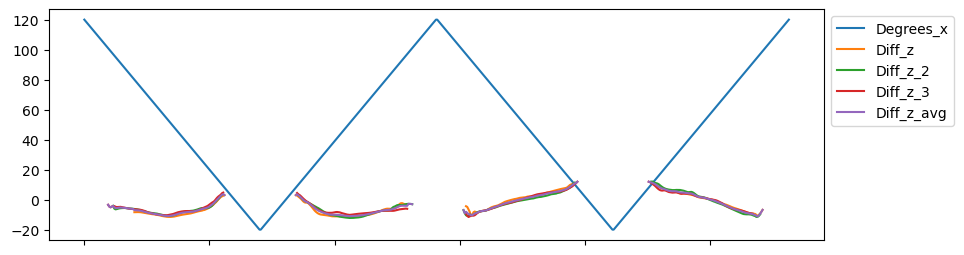

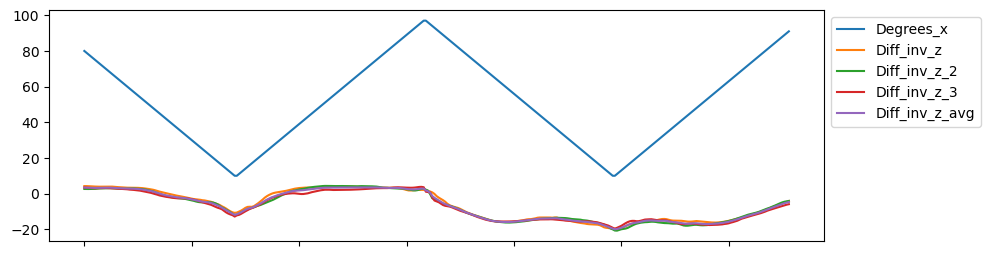

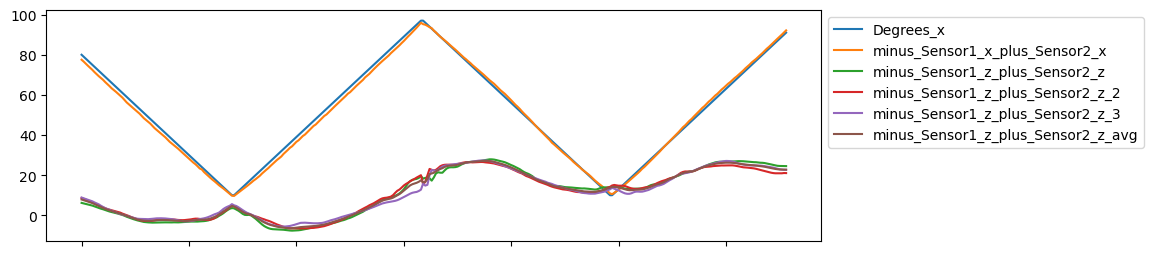

In [130]:
fig, ax = plt.subplots(figsize=(10, 3))
ax.plot(OKC_CKC_df['Degrees_x'], label='Degrees_x')
ax.plot(OKC_CKC_df['Diff_z'], label='Diff_z')
ax.plot(OKC_CKC_df['Diff_z_2'], label='Diff_z_2')
ax.plot(OKC_CKC_df['Diff_z_3'], label='Diff_z_3')
ax.plot(OKC_CKC_df['Diff_z_avg'], label='Diff_z_avg')
ax.set_xticklabels([])
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

OKC_CKC_dropped = OKC_CKC_df.dropna()

row_numbers = np.arange(len(OKC_CKC_dropped))  # Generate an array of row numbers
fig, ax = plt.subplots(figsize=(10, 3))
ax.plot(row_numbers, OKC_CKC_dropped['Degrees_x'], label='Degrees_x')
ax.plot(row_numbers, OKC_CKC_dropped['Diff_inv_z'], label='Diff_inv_z')
ax.plot(row_numbers, OKC_CKC_dropped['Diff_inv_z_2'], label='Diff_inv_z_2')
ax.plot(row_numbers, OKC_CKC_dropped['Diff_inv_z_3'], label='Diff_inv_z_3')
ax.plot(row_numbers, OKC_CKC_dropped['Diff_inv_z_avg'], label='Diff_inv_z_avg')
ax.set_xticklabels([])
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

# Plot the minus_Sensor2_z_plus_Sensor1_z values
fig, ax = plt.subplots(figsize=(10, 3))
ax.plot(row_numbers, OKC_CKC_dropped['Degrees_x'], label='Degrees_x')
ax.plot(row_numbers, OKC_CKC_dropped['minus_Sensor1_x_plus_Sensor2_x'], label='minus_Sensor1_x_plus_Sensor2_x')
ax.plot(row_numbers, OKC_CKC_dropped['minus_Sensor1_z_plus_Sensor2_z'], label='minus_Sensor1_z_plus_Sensor2_z')
ax.plot(row_numbers, OKC_CKC_dropped['minus_Sensor1_z_plus_Sensor2_z_2'], label='minus_Sensor1_z_plus_Sensor2_z_2')
ax.plot(row_numbers, OKC_CKC_dropped['minus_Sensor1_z_plus_Sensor2_z_3'], label='minus_Sensor1_z_plus_Sensor2_z_3')
ax.plot(row_numbers, OKC_CKC_dropped['minus_Sensor1_z_plus_Sensor2_z_avg'], label='minus_Sensor1_z_plus_Sensor2_z_avg')
ax.set_xticklabels([])
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.show()


**Plot individual sensors and calculated differences between Sensor 2 and Sensor 1**

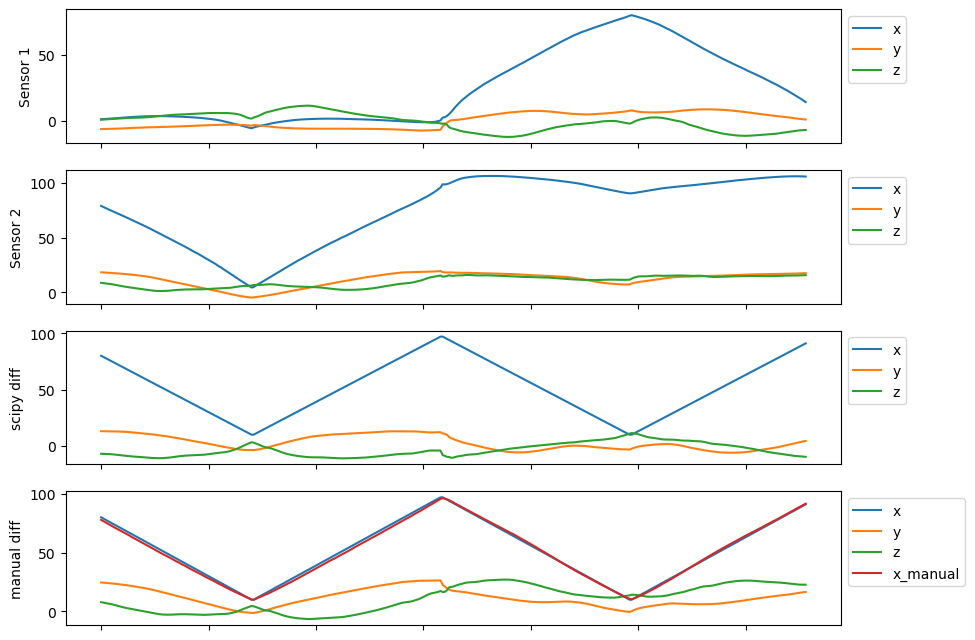

In [131]:
fig = plt.figure(figsize=(10, 8))

ax1 = fig.add_subplot(411)
ax1.plot(row_numbers, OKC_CKC_dropped['Sensor1_x_avg'])
ax1.plot(row_numbers,OKC_CKC_dropped['Sensor1_y_avg'])
ax1.plot(row_numbers,OKC_CKC_dropped['Sensor1_z_avg'])
ax1.legend(['x', 'y', 'z'], bbox_to_anchor=(1, 1), loc='upper left')
ax1.set_ylabel('Sensor 1')

ax2 = fig.add_subplot(412)
ax2.plot(row_numbers ,OKC_CKC_dropped['Sensor2_x_avg'])
ax2.plot(row_numbers ,OKC_CKC_dropped['Sensor2_y_avg'])
ax2.plot(row_numbers ,OKC_CKC_dropped['Sensor2_z_avg'])
ax2.legend(['x', 'y', 'z'], bbox_to_anchor=(1, 1), loc='upper left')
ax2.set_ylabel('Sensor 2')

ax4 = fig.add_subplot(414)
ax4.plot(row_numbers,OKC_CKC_dropped['Degrees_x'])
ax4.plot(row_numbers,OKC_CKC_dropped['minus_Sensor1_y_plus_Sensor2_y_avg'])
ax4.plot(row_numbers,OKC_CKC_dropped['minus_Sensor1_z_plus_Sensor2_z_avg'])
ax4.plot(row_numbers,OKC_CKC_dropped['minus_Sensor1_x_plus_Sensor2_x_avg'])
ax4.legend(['x', 'y', 'z', 'x_manual'], bbox_to_anchor=(1, 1), loc='upper left')
ax4.set_ylabel('manual diff')

ax3 = fig.add_subplot(413)
ax3.plot(row_numbers,OKC_CKC_dropped['Degrees_x'])
ax3.plot(row_numbers,OKC_CKC_dropped['Diff_y_avg'])
ax3.plot(row_numbers,OKC_CKC_dropped['Diff_z_avg'])
ax3.legend(['x', 'y', 'z'], bbox_to_anchor=(1, 1), loc='upper left')
ax3.set_ylabel('scipy diff')

ax1.set_xticklabels([])
ax2.set_xticklabels([])
ax3.set_xticklabels([])
ax4.set_xticklabels([])


plt.show()

**Write Data to output folder**

In [132]:
# Write OKC_CKC_df to a new csv file with the name of the original filename appended with "_analysis" in the Output folder
output_dir = 'Output/'
output_filename = name.split('.')[0] + '_analysis.csv'
OKC_CKC_df.to_csv(os.path.join(output_dir, output_filename), index=False)

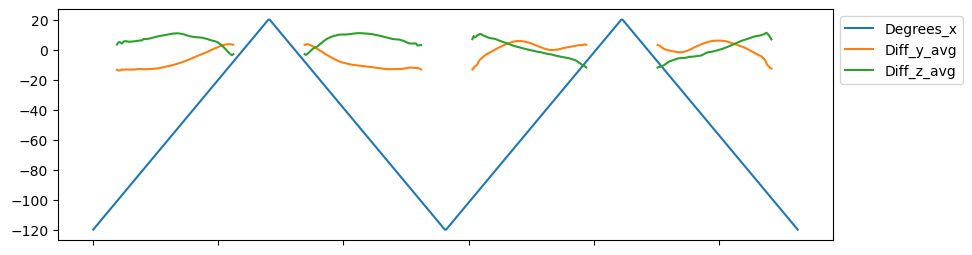

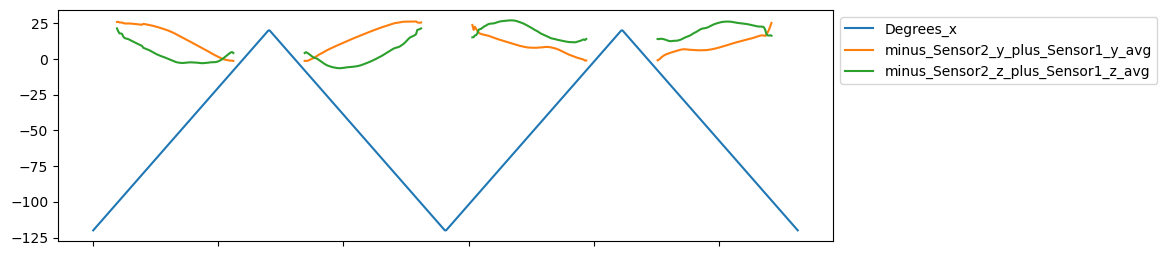

In [133]:
OKC_CKC_df_negated = -OKC_CKC_df.copy()

# plot OKC_CKC_df_negated
fig, ax = plt.subplots(figsize=(10, 3))
ax.plot(OKC_CKC_df_negated['Degrees_x'], label='Degrees_x')
ax.plot(OKC_CKC_df_negated['Diff_y_avg'], label='Diff_y_avg')
ax.plot(OKC_CKC_df_negated['Diff_z_avg'], label='Diff_z_avg')
ax.set_xticklabels([])
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

fig, ax = plt.subplots(figsize=(10, 3))
ax.plot(OKC_CKC_df_negated['Degrees_x'], label='Degrees_x')
ax.plot(OKC_CKC_df_negated['minus_Sensor2_y_plus_Sensor1_y_avg'], label='minus_Sensor2_y_plus_Sensor1_y_avg')
ax.plot(OKC_CKC_df_negated['minus_Sensor2_z_plus_Sensor1_z_avg'], label='minus_Sensor2_z_plus_Sensor1_z_avg')
ax.set_xticklabels([])
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

In [134]:
# Write OKC_CKC_df_negated to a new csv file with the name of the original filename appended with "_analysis_negated" in the Output folder
output_filename_negated = name.split('.')[0] + '_analysis_negated.csv'
OKC_CKC_df_negated.to_csv(os.path.join(output_dir, output_filename_negated), index=False)

In [135]:
OKC_extension_only_Diff_z= OKC_extension_df['Diff_z']
OKC_extension_only_Diff_z_dropped = OKC_extension_only_Diff_z.dropna()
OKC_extension_only_Diff_z_zero = OKC_extension_only_Diff_z_dropped - OKC_extension_only_Diff_z_dropped.iloc[-1]
OKC_extension_only_Diff_z_2= OKC_extension_df['Diff_z_2']
OKC_extension_only_Diff_z_2_dropped = OKC_extension_only_Diff_z_2.dropna()
OKC_extension_only_Diff_z_2_zero = OKC_extension_only_Diff_z_2_dropped - OKC_extension_only_Diff_z_2_dropped.iloc[-1]
OKC_extension_only_Diff_z_3= OKC_extension_df['Diff_z_3']
OKC_extension_only_Diff_z_3_dropped = OKC_extension_only_Diff_z_3.dropna()
OKC_extension_only_Diff_z_3_zero = OKC_extension_only_Diff_z_3_dropped - OKC_extension_only_Diff_z_3_dropped.iloc[-1]
OKC_extension_only_Diff_z_avg= OKC_extension_df['Diff_z_avg']
OKC_extension_only_Diff_z_avg_dropped = OKC_extension_only_Diff_z_avg.dropna()
OKC_extension_only_Diff_z_avg_zero = OKC_extension_only_Diff_z_avg_dropped - OKC_extension_only_Diff_z_avg_dropped.iloc[-1]
OKC_extension_only_minus_Sensor1_z_plus_Sensor2_z= OKC_extension_df['minus_Sensor1_z_plus_Sensor2_z']
OKC_extension_only_minus_Sensor1_z_plus_Sensor2_z_dropped = OKC_extension_only_minus_Sensor1_z_plus_Sensor2_z.dropna()
OKC_extension_only_minus_Sensor1_z_plus_Sensor2_z_zero = OKC_extension_only_minus_Sensor1_z_plus_Sensor2_z_dropped - OKC_extension_only_minus_Sensor1_z_plus_Sensor2_z_dropped.iloc[-1]
OKC_extension_only_minus_Sensor1_z_plus_Sensor2_z_2= OKC_extension_df['minus_Sensor1_z_plus_Sensor2_z_2']
OKC_extension_only_minus_Sensor1_z_plus_Sensor2_z_2_dropped = OKC_extension_only_minus_Sensor1_z_plus_Sensor2_z_2.dropna()
OKC_extension_only_minus_Sensor1_z_plus_Sensor2_z_2_zero = OKC_extension_only_minus_Sensor1_z_plus_Sensor2_z_2_dropped - OKC_extension_only_minus_Sensor1_z_plus_Sensor2_z_2_dropped.iloc[-1]
OKC_extension_only_minus_Sensor1_z_plus_Sensor2_z_3= OKC_extension_df['minus_Sensor1_z_plus_Sensor2_z_3']
OKC_extension_only_minus_Sensor1_z_plus_Sensor2_z_3_dropped = OKC_extension_only_minus_Sensor1_z_plus_Sensor2_z_3.dropna()
OKC_extension_only_minus_Sensor1_z_plus_Sensor2_z_3_zero = OKC_extension_only_minus_Sensor1_z_plus_Sensor2_z_3_dropped - OKC_extension_only_minus_Sensor1_z_plus_Sensor2_z_3_dropped.iloc[-1]
OKC_extension_only_minus_Sensor1_z_plus_Sensor2_z_avg= OKC_extension_df['minus_Sensor1_z_plus_Sensor2_z_avg']
OKC_extension_only_minus_Sensor1_z_plus_Sensor2_z_avg_dropped = OKC_extension_only_minus_Sensor1_z_plus_Sensor2_z_avg.dropna()
OKC_extension_only_minus_Sensor1_z_plus_Sensor2_z_avg_zero = OKC_extension_only_minus_Sensor1_z_plus_Sensor2_z_avg_dropped - OKC_extension_only_minus_Sensor1_z_plus_Sensor2_z_avg_dropped.iloc[-1]
OKC_extension_only_minus_Sensor2_z_plus_Sensor1_z= OKC_extension_df['minus_Sensor2_z_plus_Sensor1_z']
OKC_extension_only_minus_Sensor2_z_plus_Sensor1_z_dropped = OKC_extension_only_minus_Sensor2_z_plus_Sensor1_z.dropna()
OKC_extension_only_minus_Sensor2_z_plus_Sensor1_z_zero = OKC_extension_only_minus_Sensor2_z_plus_Sensor1_z_dropped - OKC_extension_only_minus_Sensor2_z_plus_Sensor1_z_dropped.iloc[-1]
OKC_extension_only_minus_Sensor2_z_plus_Sensor1_z_2= OKC_extension_df['minus_Sensor2_z_plus_Sensor1_z_2']
OKC_extension_only_minus_Sensor2_z_plus_Sensor1_z_2_dropped = OKC_extension_only_minus_Sensor2_z_plus_Sensor1_z_2.dropna()
OKC_extension_only_minus_Sensor2_z_plus_Sensor1_z_2_zero = OKC_extension_only_minus_Sensor2_z_plus_Sensor1_z_2_dropped - OKC_extension_only_minus_Sensor2_z_plus_Sensor1_z_2_dropped.iloc[-1]
OKC_extension_only_minus_Sensor2_z_plus_Sensor1_z_3= OKC_extension_df['minus_Sensor2_z_plus_Sensor1_z_3']
OKC_extension_only_minus_Sensor2_z_plus_Sensor1_z_3_dropped = OKC_extension_only_minus_Sensor2_z_plus_Sensor1_z_3.dropna()
OKC_extension_only_minus_Sensor2_z_plus_Sensor1_z_3_zero = OKC_extension_only_minus_Sensor2_z_plus_Sensor1_z_3_dropped - OKC_extension_only_minus_Sensor2_z_plus_Sensor1_z_3_dropped.iloc[-1]
OKC_extension_only_minus_Sensor2_z_plus_Sensor1_z_avg= OKC_extension_df['minus_Sensor2_z_plus_Sensor1_z_avg']
OKC_extension_only_minus_Sensor2_z_plus_Sensor1_z_avg_dropped = OKC_extension_only_minus_Sensor2_z_plus_Sensor1_z_avg.dropna()
OKC_extension_only_minus_Sensor2_z_plus_Sensor1_z_avg_zero = OKC_extension_only_minus_Sensor2_z_plus_Sensor1_z_avg_dropped - OKC_extension_only_minus_Sensor2_z_plus_Sensor1_z_avg_dropped.iloc[-1]

OKC_flexion_only_Diff_z= OKC_flexion_df['Diff_z']
OKC_flexion_only_Diff_z_dropped = OKC_flexion_only_Diff_z.dropna()
OKC_flexion_only_Diff_z_zero = OKC_flexion_only_Diff_z_dropped - OKC_flexion_only_Diff_z_dropped.iloc[0]
OKC_flexion_only_Diff_z_2= OKC_flexion_df['Diff_z_2']
OKC_flexion_only_Diff_z_2_dropped = OKC_flexion_only_Diff_z_2.dropna()
OKC_flexion_only_Diff_z_2_zero = OKC_flexion_only_Diff_z_2_dropped - OKC_flexion_only_Diff_z_2_dropped.iloc[0]
OKC_flexion_only_Diff_z_3= OKC_flexion_df['Diff_z_3']
OKC_flexion_only_Diff_z_3_dropped = OKC_flexion_only_Diff_z_3.dropna()
OKC_flexion_only_Diff_z_3_zero = OKC_flexion_only_Diff_z_3_dropped - OKC_flexion_only_Diff_z_3_dropped.iloc[0]
OKC_flexion_only_Diff_z_avg= OKC_flexion_df['Diff_z_avg']
OKC_flexion_only_Diff_z_avg_dropped = OKC_flexion_only_Diff_z_avg.dropna()
OKC_flexion_only_Diff_z_avg_zero = OKC_flexion_only_Diff_z_avg_dropped - OKC_flexion_only_Diff_z_avg_dropped.iloc[0]
OKC_flexion_only_minus_Sensor1_z_plus_Sensor2_z= OKC_flexion_df['minus_Sensor1_z_plus_Sensor2_z']
OKC_flexion_only_minus_Sensor1_z_plus_Sensor2_z_dropped = OKC_flexion_only_minus_Sensor1_z_plus_Sensor2_z.dropna()
OKC_flexion_only_minus_Sensor1_z_plus_Sensor2_z_zero = OKC_flexion_only_minus_Sensor1_z_plus_Sensor2_z_dropped - OKC_flexion_only_minus_Sensor1_z_plus_Sensor2_z_dropped.iloc[0]
OKC_flexion_only_minus_Sensor1_z_plus_Sensor2_z_2= OKC_flexion_df['minus_Sensor1_z_plus_Sensor2_z_2']
OKC_flexion_only_minus_Sensor1_z_plus_Sensor2_z_2_dropped = OKC_flexion_only_minus_Sensor1_z_plus_Sensor2_z_2.dropna()
OKC_flexion_only_minus_Sensor1_z_plus_Sensor2_z_2_zero = OKC_flexion_only_minus_Sensor1_z_plus_Sensor2_z_2_dropped - OKC_flexion_only_minus_Sensor1_z_plus_Sensor2_z_2_dropped.iloc[0]
OKC_flexion_only_minus_Sensor1_z_plus_Sensor2_z_3= OKC_flexion_df['minus_Sensor1_z_plus_Sensor2_z_3']
OKC_flexion_only_minus_Sensor1_z_plus_Sensor2_z_3_dropped = OKC_flexion_only_minus_Sensor1_z_plus_Sensor2_z_3.dropna()
OKC_flexion_only_minus_Sensor1_z_plus_Sensor2_z_3_zero = OKC_flexion_only_minus_Sensor1_z_plus_Sensor2_z_3_dropped - OKC_flexion_only_minus_Sensor1_z_plus_Sensor2_z_3_dropped.iloc[0]
OKC_flexion_only_minus_Sensor1_z_plus_Sensor2_z_avg= OKC_flexion_df['minus_Sensor1_z_plus_Sensor2_z_avg']
OKC_flexion_only_minus_Sensor1_z_plus_Sensor2_z_avg_dropped = OKC_flexion_only_minus_Sensor1_z_plus_Sensor2_z_avg.dropna()
OKC_flexion_only_minus_Sensor1_z_plus_Sensor2_z_avg_zero = OKC_flexion_only_minus_Sensor1_z_plus_Sensor2_z_avg_dropped - OKC_flexion_only_minus_Sensor1_z_plus_Sensor2_z_avg_dropped.iloc[0]
OKC_flexion_only_minus_Sensor2_z_plus_Sensor1_z= OKC_flexion_df['minus_Sensor2_z_plus_Sensor1_z']
OKC_flexion_only_minus_Sensor2_z_plus_Sensor1_z_dropped = OKC_flexion_only_minus_Sensor2_z_plus_Sensor1_z.dropna()
OKC_flexion_only_minus_Sensor2_z_plus_Sensor1_z_zero = OKC_flexion_only_minus_Sensor2_z_plus_Sensor1_z_dropped - OKC_flexion_only_minus_Sensor2_z_plus_Sensor1_z_dropped.iloc[0]
OKC_flexion_only_minus_Sensor2_z_plus_Sensor1_z_2= OKC_flexion_df['minus_Sensor2_z_plus_Sensor1_z_2']
OKC_flexion_only_minus_Sensor2_z_plus_Sensor1_z_2_dropped = OKC_flexion_only_minus_Sensor2_z_plus_Sensor1_z_2.dropna()
OKC_flexion_only_minus_Sensor2_z_plus_Sensor1_z_2_zero = OKC_flexion_only_minus_Sensor2_z_plus_Sensor1_z_2_dropped - OKC_flexion_only_minus_Sensor2_z_plus_Sensor1_z_2_dropped.iloc[0]
OKC_flexion_only_minus_Sensor2_z_plus_Sensor1_z_3= OKC_flexion_df['minus_Sensor2_z_plus_Sensor1_z_3']
OKC_flexion_only_minus_Sensor2_z_plus_Sensor1_z_3_dropped = OKC_flexion_only_minus_Sensor2_z_plus_Sensor1_z_3.dropna()
OKC_flexion_only_minus_Sensor2_z_plus_Sensor1_z_3_zero = OKC_flexion_only_minus_Sensor2_z_plus_Sensor1_z_3_dropped - OKC_flexion_only_minus_Sensor2_z_plus_Sensor1_z_3_dropped.iloc[0]
OKC_flexion_only_minus_Sensor2_z_plus_Sensor1_z_avg= OKC_flexion_df['minus_Sensor2_z_plus_Sensor1_z_avg']
OKC_flexion_only_minus_Sensor2_z_plus_Sensor1_z_avg_dropped = OKC_flexion_only_minus_Sensor2_z_plus_Sensor1_z_avg.dropna()
OKC_flexion_only_minus_Sensor2_z_plus_Sensor1_z_avg_zero = OKC_flexion_only_minus_Sensor2_z_plus_Sensor1_z_avg_dropped - OKC_flexion_only_minus_Sensor2_z_plus_Sensor1_z_avg_dropped.iloc[0]

CKC_extension_only_Diff_z= CKC_extension_df['Diff_z']
CKC_extension_only_Diff_z_dropped = CKC_extension_only_Diff_z.dropna()
CKC_extension_only_Diff_z_zero = CKC_extension_only_Diff_z_dropped - CKC_extension_only_Diff_z_dropped.iloc[-1]
CKC_extension_only_Diff_z_2= CKC_extension_df['Diff_z_2']
CKC_extension_only_Diff_z_2_dropped = CKC_extension_only_Diff_z_2.dropna()
CKC_extension_only_Diff_z_2_zero = CKC_extension_only_Diff_z_2_dropped - CKC_extension_only_Diff_z_2_dropped.iloc[-1]
CKC_extension_only_Diff_z_3= CKC_extension_df['Diff_z_3']
CKC_extension_only_Diff_z_3_dropped = CKC_extension_only_Diff_z_3.dropna()
CKC_extension_only_Diff_z_3_zero = CKC_extension_only_Diff_z_3_dropped - CKC_extension_only_Diff_z_3_dropped.iloc[-1]
CKC_extension_only_Diff_z_avg= CKC_extension_df['Diff_z_avg']
CKC_extension_only_Diff_z_avg_dropped = CKC_extension_only_Diff_z_avg.dropna()
CKC_extension_only_Diff_z_avg_zero = CKC_extension_only_Diff_z_avg_dropped - CKC_extension_only_Diff_z_avg_dropped.iloc[-1]
CKC_extension_only_minus_Sensor1_z_plus_Sensor2_z= CKC_extension_df['minus_Sensor1_z_plus_Sensor2_z']
CKC_extension_only_minus_Sensor1_z_plus_Sensor2_z_dropped = CKC_extension_only_minus_Sensor1_z_plus_Sensor2_z.dropna()
CKC_extension_only_minus_Sensor1_z_plus_Sensor2_z_zero = CKC_extension_only_minus_Sensor1_z_plus_Sensor2_z_dropped - CKC_extension_only_minus_Sensor1_z_plus_Sensor2_z_dropped.iloc[-1]
CKC_extension_only_minus_Sensor1_z_plus_Sensor2_z_2= CKC_extension_df['minus_Sensor1_z_plus_Sensor2_z_2']
CKC_extension_only_minus_Sensor1_z_plus_Sensor2_z_2_dropped = CKC_extension_only_minus_Sensor1_z_plus_Sensor2_z_2.dropna()
CKC_extension_only_minus_Sensor1_z_plus_Sensor2_z_2_zero = CKC_extension_only_minus_Sensor1_z_plus_Sensor2_z_2_dropped - CKC_extension_only_minus_Sensor1_z_plus_Sensor2_z_2_dropped.iloc[-1]
CKC_extension_only_minus_Sensor1_z_plus_Sensor2_z_3= CKC_extension_df['minus_Sensor1_z_plus_Sensor2_z_3']
CKC_extension_only_minus_Sensor1_z_plus_Sensor2_z_3_dropped = CKC_extension_only_minus_Sensor1_z_plus_Sensor2_z_3.dropna()
CKC_extension_only_minus_Sensor1_z_plus_Sensor2_z_3_zero = CKC_extension_only_minus_Sensor1_z_plus_Sensor2_z_3_dropped - CKC_extension_only_minus_Sensor1_z_plus_Sensor2_z_3_dropped.iloc[-1]
CKC_extension_only_minus_Sensor1_z_plus_Sensor2_z_avg= CKC_extension_df['minus_Sensor1_z_plus_Sensor2_z_avg']
CKC_extension_only_minus_Sensor1_z_plus_Sensor2_z_avg_dropped = CKC_extension_only_minus_Sensor1_z_plus_Sensor2_z_avg.dropna()
CKC_extension_only_minus_Sensor1_z_plus_Sensor2_z_avg_zero = CKC_extension_only_minus_Sensor1_z_plus_Sensor2_z_avg_dropped - CKC_extension_only_minus_Sensor1_z_plus_Sensor2_z_avg_dropped.iloc[-1]
CKC_extension_only_minus_Sensor2_z_plus_Sensor1_z= CKC_extension_df['minus_Sensor2_z_plus_Sensor1_z']
CKC_extension_only_minus_Sensor2_z_plus_Sensor1_z_dropped = CKC_extension_only_minus_Sensor2_z_plus_Sensor1_z.dropna()
CKC_extension_only_minus_Sensor2_z_plus_Sensor1_z_zero = CKC_extension_only_minus_Sensor2_z_plus_Sensor1_z_dropped - CKC_extension_only_minus_Sensor2_z_plus_Sensor1_z_dropped.iloc[-1]
CKC_extension_only_minus_Sensor2_z_plus_Sensor1_z_2= CKC_extension_df['minus_Sensor2_z_plus_Sensor1_z_2']
CKC_extension_only_minus_Sensor2_z_plus_Sensor1_z_2_dropped = CKC_extension_only_minus_Sensor2_z_plus_Sensor1_z_2.dropna()
CKC_extension_only_minus_Sensor2_z_plus_Sensor1_z_2_zero = CKC_extension_only_minus_Sensor2_z_plus_Sensor1_z_2_dropped - CKC_extension_only_minus_Sensor2_z_plus_Sensor1_z_2_dropped.iloc[-1]
CKC_extension_only_minus_Sensor2_z_plus_Sensor1_z_3= CKC_extension_df['minus_Sensor2_z_plus_Sensor1_z_3']
CKC_extension_only_minus_Sensor2_z_plus_Sensor1_z_3_dropped = CKC_extension_only_minus_Sensor2_z_plus_Sensor1_z_3.dropna()
CKC_extension_only_minus_Sensor2_z_plus_Sensor1_z_3_zero = CKC_extension_only_minus_Sensor2_z_plus_Sensor1_z_3_dropped - CKC_extension_only_minus_Sensor2_z_plus_Sensor1_z_3_dropped.iloc[-1]
CKC_extension_only_minus_Sensor2_z_plus_Sensor1_z_avg= CKC_extension_df['minus_Sensor2_z_plus_Sensor1_z_avg']
CKC_extension_only_minus_Sensor2_z_plus_Sensor1_z_avg_dropped = CKC_extension_only_minus_Sensor2_z_plus_Sensor1_z_avg.dropna()
CKC_extension_only_minus_Sensor2_z_plus_Sensor1_z_avg_zero = CKC_extension_only_minus_Sensor2_z_plus_Sensor1_z_avg_dropped - CKC_extension_only_minus_Sensor2_z_plus_Sensor1_z_avg_dropped.iloc[-1]

CKC_flexion_only_Diff_z= CKC_flexion_df['Diff_z']
CKC_flexion_only_Diff_z_dropped = CKC_flexion_only_Diff_z.dropna()
CKC_flexion_only_Diff_z_zero = CKC_flexion_only_Diff_z_dropped - CKC_flexion_only_Diff_z_dropped.iloc[0]
CKC_flexion_only_Diff_z_2= CKC_flexion_df['Diff_z_2']
CKC_flexion_only_Diff_z_2_dropped = CKC_flexion_only_Diff_z_2.dropna()
CKC_flexion_only_Diff_z_2_zero = CKC_flexion_only_Diff_z_2_dropped - CKC_flexion_only_Diff_z_2_dropped.iloc[0]
CKC_flexion_only_Diff_z_3= CKC_flexion_df['Diff_z_3']
CKC_flexion_only_Diff_z_3_dropped = CKC_flexion_only_Diff_z_3.dropna()
CKC_flexion_only_Diff_z_3_zero = CKC_flexion_only_Diff_z_3_dropped - CKC_flexion_only_Diff_z_3_dropped.iloc[0]
CKC_flexion_only_Diff_z_avg= CKC_flexion_df['Diff_z_avg']
CKC_flexion_only_Diff_z_avg_dropped = CKC_flexion_only_Diff_z_avg.dropna()
CKC_flexion_only_Diff_z_avg_zero = CKC_flexion_only_Diff_z_avg_dropped - CKC_flexion_only_Diff_z_avg_dropped.iloc[0]
CKC_flexion_only_minus_Sensor1_z_plus_Sensor2_z= CKC_flexion_df['minus_Sensor1_z_plus_Sensor2_z']
CKC_flexion_only_minus_Sensor1_z_plus_Sensor2_z_dropped = CKC_flexion_only_minus_Sensor1_z_plus_Sensor2_z.dropna()
CKC_flexion_only_minus_Sensor1_z_plus_Sensor2_z_zero = CKC_flexion_only_minus_Sensor1_z_plus_Sensor2_z_dropped - CKC_flexion_only_minus_Sensor1_z_plus_Sensor2_z_dropped.iloc[0]
CKC_flexion_only_minus_Sensor1_z_plus_Sensor2_z_2= CKC_flexion_df['minus_Sensor1_z_plus_Sensor2_z_2']
CKC_flexion_only_minus_Sensor1_z_plus_Sensor2_z_2_dropped = CKC_flexion_only_minus_Sensor1_z_plus_Sensor2_z_2.dropna()
CKC_flexion_only_minus_Sensor1_z_plus_Sensor2_z_2_zero = CKC_flexion_only_minus_Sensor1_z_plus_Sensor2_z_2_dropped - CKC_flexion_only_minus_Sensor1_z_plus_Sensor2_z_2_dropped.iloc[0]
CKC_flexion_only_minus_Sensor1_z_plus_Sensor2_z_3= CKC_flexion_df['minus_Sensor1_z_plus_Sensor2_z_3']
CKC_flexion_only_minus_Sensor1_z_plus_Sensor2_z_3_dropped = CKC_flexion_only_minus_Sensor1_z_plus_Sensor2_z_3.dropna()
CKC_flexion_only_minus_Sensor1_z_plus_Sensor2_z_3_zero = CKC_flexion_only_minus_Sensor1_z_plus_Sensor2_z_3_dropped - CKC_flexion_only_minus_Sensor1_z_plus_Sensor2_z_3_dropped.iloc[0]
CKC_flexion_only_minus_Sensor1_z_plus_Sensor2_z_avg= CKC_flexion_df['minus_Sensor1_z_plus_Sensor2_z_avg']
CKC_flexion_only_minus_Sensor1_z_plus_Sensor2_z_avg_dropped = CKC_flexion_only_minus_Sensor1_z_plus_Sensor2_z_avg.dropna()
CKC_flexion_only_minus_Sensor1_z_plus_Sensor2_z_avg_zero = CKC_flexion_only_minus_Sensor1_z_plus_Sensor2_z_avg_dropped - CKC_flexion_only_minus_Sensor1_z_plus_Sensor2_z_avg_dropped.iloc[0]
CKC_flexion_only_minus_Sensor2_z_plus_Sensor1_z= CKC_flexion_df['minus_Sensor2_z_plus_Sensor1_z']
CKC_flexion_only_minus_Sensor2_z_plus_Sensor1_z_dropped = CKC_flexion_only_minus_Sensor2_z_plus_Sensor1_z.dropna()
CKC_flexion_only_minus_Sensor2_z_plus_Sensor1_z_zero = CKC_flexion_only_minus_Sensor2_z_plus_Sensor1_z_dropped - CKC_flexion_only_minus_Sensor2_z_plus_Sensor1_z_dropped.iloc[0]
CKC_flexion_only_minus_Sensor2_z_plus_Sensor1_z_2= CKC_flexion_df['minus_Sensor2_z_plus_Sensor1_z_2']
CKC_flexion_only_minus_Sensor2_z_plus_Sensor1_z_2_dropped = CKC_flexion_only_minus_Sensor2_z_plus_Sensor1_z_2.dropna()
CKC_flexion_only_minus_Sensor2_z_plus_Sensor1_z_2_zero = CKC_flexion_only_minus_Sensor2_z_plus_Sensor1_z_2_dropped - CKC_flexion_only_minus_Sensor2_z_plus_Sensor1_z_2_dropped.iloc[0]
CKC_flexion_only_minus_Sensor2_z_plus_Sensor1_z_3= CKC_flexion_df['minus_Sensor2_z_plus_Sensor1_z_3']
CKC_flexion_only_minus_Sensor2_z_plus_Sensor1_z_3_dropped = CKC_flexion_only_minus_Sensor2_z_plus_Sensor1_z_3.dropna()
CKC_flexion_only_minus_Sensor2_z_plus_Sensor1_z_3_zero = CKC_flexion_only_minus_Sensor2_z_plus_Sensor1_z_3_dropped - CKC_flexion_only_minus_Sensor2_z_plus_Sensor1_z_3_dropped.iloc[0]
CKC_flexion_only_minus_Sensor2_z_plus_Sensor1_z_avg= CKC_flexion_df['minus_Sensor2_z_plus_Sensor1_z_avg']
CKC_flexion_only_minus_Sensor2_z_plus_Sensor1_z_avg_dropped = CKC_flexion_only_minus_Sensor2_z_plus_Sensor1_z_avg.dropna()
CKC_flexion_only_minus_Sensor2_z_plus_Sensor1_z_avg_zero = CKC_flexion_only_minus_Sensor2_z_plus_Sensor1_z_avg_dropped - CKC_flexion_only_minus_Sensor2_z_plus_Sensor1_z_avg_dropped.iloc[0]

# Reverse the columns
# Extension
OKC_extension_only_Diff_z_dropped_rev = OKC_extension_only_Diff_z_dropped.iloc[::-1]
OKC_extension_only_Diff_z_2_dropped_rev = OKC_extension_only_Diff_z_2_dropped.iloc[::-1]
OKC_extension_only_Diff_z_3_dropped_rev = OKC_extension_only_Diff_z_3_dropped.iloc[::-1]
OKC_extension_only_Diff_z_avg_dropped_rev = OKC_extension_only_Diff_z_avg_dropped.iloc[::-1]
OKC_extension_only_minus_Sensor1_z_plus_Sensor2_z_dropped_rev = OKC_extension_only_minus_Sensor1_z_plus_Sensor2_z_dropped.iloc[::-1]
OKC_extension_only_minus_Sensor1_z_plus_Sensor2_z_2_dropped_rev = OKC_extension_only_minus_Sensor1_z_plus_Sensor2_z_2_dropped.iloc[::-1]
OKC_extension_only_minus_Sensor1_z_plus_Sensor2_z_3_dropped_rev = OKC_extension_only_minus_Sensor1_z_plus_Sensor2_z_3_dropped.iloc[::-1]
OKC_extension_only_minus_Sensor1_z_plus_Sensor2_z_avg_dropped_rev = OKC_extension_only_minus_Sensor1_z_plus_Sensor2_z_avg_dropped.iloc[::-1]
OKC_extension_only_minus_Sensor2_z_plus_Sensor1_z_dropped_rev = OKC_extension_only_minus_Sensor2_z_plus_Sensor1_z_dropped.iloc[::-1]
OKC_extension_only_minus_Sensor2_z_plus_Sensor1_z_2_dropped_rev = OKC_extension_only_minus_Sensor2_z_plus_Sensor1_z_2_dropped.iloc[::-1]
OKC_extension_only_minus_Sensor2_z_plus_Sensor1_z_3_dropped_rev = OKC_extension_only_minus_Sensor2_z_plus_Sensor1_z_3_dropped.iloc[::-1]
OKC_extension_only_minus_Sensor2_z_plus_Sensor1_z_avg_dropped_rev = OKC_extension_only_minus_Sensor2_z_plus_Sensor1_z_avg_dropped.iloc[::-1]

CKC_extension_only_Diff_z_dropped_rev = CKC_extension_only_Diff_z_dropped.iloc[::-1]
CKC_extension_only_Diff_z_2_dropped_rev = CKC_extension_only_Diff_z_2_dropped.iloc[::-1]
CKC_extension_only_Diff_z_3_dropped_rev = CKC_extension_only_Diff_z_3_dropped.iloc[::-1]
CKC_extension_only_Diff_z_avg_dropped_rev = CKC_extension_only_Diff_z_avg_dropped.iloc[::-1]
CKC_extension_only_minus_Sensor1_z_plus_Sensor2_z_dropped_rev = CKC_extension_only_minus_Sensor1_z_plus_Sensor2_z_dropped.iloc[::-1]
CKC_extension_only_minus_Sensor1_z_plus_Sensor2_z_2_dropped_rev = CKC_extension_only_minus_Sensor1_z_plus_Sensor2_z_2_dropped.iloc[::-1]
CKC_extension_only_minus_Sensor1_z_plus_Sensor2_z_3_dropped_rev = CKC_extension_only_minus_Sensor1_z_plus_Sensor2_z_3_dropped.iloc[::-1]
CKC_extension_only_minus_Sensor1_z_plus_Sensor2_z_avg_dropped_rev = CKC_extension_only_minus_Sensor1_z_plus_Sensor2_z_avg_dropped.iloc[::-1]
CKC_extension_only_minus_Sensor2_z_plus_Sensor1_z_dropped_rev = CKC_extension_only_minus_Sensor2_z_plus_Sensor1_z_dropped.iloc[::-1]
CKC_extension_only_minus_Sensor2_z_plus_Sensor1_z_2_dropped_rev = CKC_extension_only_minus_Sensor2_z_plus_Sensor1_z_2_dropped.iloc[::-1]
CKC_extension_only_minus_Sensor2_z_plus_Sensor1_z_3_dropped_rev = CKC_extension_only_minus_Sensor2_z_plus_Sensor1_z_3_dropped.iloc[::-1]
CKC_extension_only_minus_Sensor2_z_plus_Sensor1_z_avg_dropped_rev = CKC_extension_only_minus_Sensor2_z_plus_Sensor1_z_avg_dropped.iloc[::-1]

OKC_extension_only_Diff_z_zero_rev = OKC_extension_only_Diff_z_zero.iloc[::-1]
OKC_extension_only_Diff_z_2_zero_rev = OKC_extension_only_Diff_z_2_zero.iloc[::-1]
OKC_extension_only_Diff_z_3_zero_rev = OKC_extension_only_Diff_z_3_zero.iloc[::-1]
OKC_extension_only_Diff_z_avg_zero_rev = OKC_extension_only_Diff_z_avg_zero.iloc[::-1]
OKC_extension_only_minus_Sensor1_z_plus_Sensor2_z_zero_rev = OKC_extension_only_minus_Sensor1_z_plus_Sensor2_z_zero.iloc[::-1]
OKC_extension_only_minus_Sensor1_z_plus_Sensor2_z_2_zero_rev = OKC_extension_only_minus_Sensor1_z_plus_Sensor2_z_2_zero.iloc[::-1]
OKC_extension_only_minus_Sensor1_z_plus_Sensor2_z_3_zero_rev = OKC_extension_only_minus_Sensor1_z_plus_Sensor2_z_3_zero.iloc[::-1]
OKC_extension_only_minus_Sensor1_z_plus_Sensor2_z_avg_zero_rev = OKC_extension_only_minus_Sensor1_z_plus_Sensor2_z_avg_zero.iloc[::-1]
OKC_extension_only_minus_Sensor2_z_plus_Sensor1_z_zero_rev = OKC_extension_only_minus_Sensor2_z_plus_Sensor1_z_zero.iloc[::-1]
OKC_extension_only_minus_Sensor2_z_plus_Sensor1_z_2_zero_rev = OKC_extension_only_minus_Sensor2_z_plus_Sensor1_z_2_zero.iloc[::-1]
OKC_extension_only_minus_Sensor2_z_plus_Sensor1_z_3_zero_rev = OKC_extension_only_minus_Sensor2_z_plus_Sensor1_z_3_zero.iloc[::-1]
OKC_extension_only_minus_Sensor2_z_plus_Sensor1_z_avg_zero_rev = OKC_extension_only_minus_Sensor2_z_plus_Sensor1_z_avg_zero.iloc[::-1]

CKC_extension_only_Diff_z_zero_rev = CKC_extension_only_Diff_z_zero.iloc[::-1]
CKC_extension_only_Diff_z_2_zero_rev = CKC_extension_only_Diff_z_2_zero.iloc[::-1]
CKC_extension_only_Diff_z_3_zero_rev = CKC_extension_only_Diff_z_3_zero.iloc[::-1]
CKC_extension_only_Diff_z_avg_zero_rev = CKC_extension_only_Diff_z_avg_zero.iloc[::-1]
CKC_extension_only_minus_Sensor1_z_plus_Sensor2_z_zero_rev = CKC_extension_only_minus_Sensor1_z_plus_Sensor2_z_zero.iloc[::-1]
CKC_extension_only_minus_Sensor1_z_plus_Sensor2_z_2_zero_rev = CKC_extension_only_minus_Sensor1_z_plus_Sensor2_z_2_zero.iloc[::-1]
CKC_extension_only_minus_Sensor1_z_plus_Sensor2_z_3_zero_rev = CKC_extension_only_minus_Sensor1_z_plus_Sensor2_z_3_zero.iloc[::-1]
CKC_extension_only_minus_Sensor1_z_plus_Sensor2_z_avg_zero_rev = CKC_extension_only_minus_Sensor1_z_plus_Sensor2_z_avg_zero.iloc[::-1]
CKC_extension_only_minus_Sensor2_z_plus_Sensor1_z_zero_rev = CKC_extension_only_minus_Sensor2_z_plus_Sensor1_z_zero.iloc[::-1]
CKC_extension_only_minus_Sensor2_z_plus_Sensor1_z_2_zero_rev = CKC_extension_only_minus_Sensor2_z_plus_Sensor1_z_2_zero.iloc[::-1]
CKC_extension_only_minus_Sensor2_z_plus_Sensor1_z_3_zero_rev = CKC_extension_only_minus_Sensor2_z_plus_Sensor1_z_3_zero.iloc[::-1]
CKC_extension_only_minus_Sensor2_z_plus_Sensor1_z_avg_zero_rev = CKC_extension_only_minus_Sensor2_z_plus_Sensor1_z_avg_zero.iloc[::-1]


# Reset index
# Extension
OKC_extension_only_Diff_z_dropped_rev.reset_index(drop=True, inplace=True)
OKC_extension_only_Diff_z_2_dropped_rev.reset_index(drop=True, inplace=True)
OKC_extension_only_Diff_z_3_dropped_rev.reset_index(drop=True, inplace=True)
OKC_extension_only_Diff_z_avg_dropped_rev.reset_index(drop=True, inplace=True)
OKC_extension_only_minus_Sensor1_z_plus_Sensor2_z_dropped_rev.reset_index(drop=True, inplace=True)
OKC_extension_only_minus_Sensor1_z_plus_Sensor2_z_2_dropped_rev.reset_index(drop=True, inplace=True)
OKC_extension_only_minus_Sensor1_z_plus_Sensor2_z_3_dropped_rev.reset_index(drop=True, inplace=True)
OKC_extension_only_minus_Sensor1_z_plus_Sensor2_z_avg_dropped_rev.reset_index(drop=True, inplace=True)
OKC_extension_only_minus_Sensor2_z_plus_Sensor1_z_dropped_rev.reset_index(drop=True, inplace=True)
OKC_extension_only_minus_Sensor2_z_plus_Sensor1_z_2_dropped_rev.reset_index(drop=True, inplace=True)
OKC_extension_only_minus_Sensor2_z_plus_Sensor1_z_3_dropped_rev.reset_index(drop=True, inplace=True)
OKC_extension_only_minus_Sensor2_z_plus_Sensor1_z_avg_dropped_rev.reset_index(drop=True, inplace=True)

CKC_extension_only_Diff_z_dropped_rev.reset_index(drop=True, inplace=True)
CKC_extension_only_Diff_z_2_dropped_rev.reset_index(drop=True, inplace=True)
CKC_extension_only_Diff_z_3_dropped_rev.reset_index(drop=True, inplace=True)
CKC_extension_only_Diff_z_avg_dropped_rev.reset_index(drop=True, inplace=True)
CKC_extension_only_minus_Sensor1_z_plus_Sensor2_z_dropped_rev.reset_index(drop=True, inplace=True)
CKC_extension_only_minus_Sensor1_z_plus_Sensor2_z_2_dropped_rev.reset_index(drop=True, inplace=True)
CKC_extension_only_minus_Sensor1_z_plus_Sensor2_z_3_dropped_rev.reset_index(drop=True, inplace=True)
CKC_extension_only_minus_Sensor1_z_plus_Sensor2_z_avg_dropped_rev.reset_index(drop=True, inplace=True)
CKC_extension_only_minus_Sensor2_z_plus_Sensor1_z_dropped_rev.reset_index(drop=True, inplace=True)
CKC_extension_only_minus_Sensor2_z_plus_Sensor1_z_2_dropped_rev.reset_index(drop=True, inplace=True)
CKC_extension_only_minus_Sensor2_z_plus_Sensor1_z_3_dropped_rev.reset_index(drop=True, inplace=True)
CKC_extension_only_minus_Sensor2_z_plus_Sensor1_z_avg_dropped_rev.reset_index(drop=True, inplace=True)

OKC_extension_only_Diff_z_zero_rev.reset_index(drop=True, inplace=True)
OKC_extension_only_Diff_z_2_zero_rev.reset_index(drop=True, inplace=True)
OKC_extension_only_Diff_z_3_zero_rev.reset_index(drop=True, inplace=True)
OKC_extension_only_Diff_z_avg_zero_rev.reset_index(drop=True, inplace=True)
OKC_extension_only_minus_Sensor1_z_plus_Sensor2_z_zero_rev.reset_index(drop=True, inplace=True)
OKC_extension_only_minus_Sensor1_z_plus_Sensor2_z_2_zero_rev.reset_index(drop=True, inplace=True)
OKC_extension_only_minus_Sensor1_z_plus_Sensor2_z_3_zero_rev.reset_index(drop=True, inplace=True)
OKC_extension_only_minus_Sensor1_z_plus_Sensor2_z_avg_zero_rev.reset_index(drop=True, inplace=True)
OKC_extension_only_minus_Sensor2_z_plus_Sensor1_z_zero_rev.reset_index(drop=True, inplace=True)
OKC_extension_only_minus_Sensor2_z_plus_Sensor1_z_2_zero_rev.reset_index(drop=True, inplace=True)
OKC_extension_only_minus_Sensor2_z_plus_Sensor1_z_3_zero_rev.reset_index(drop=True, inplace=True)
OKC_extension_only_minus_Sensor2_z_plus_Sensor1_z_avg_zero_rev.reset_index(drop=True, inplace=True)

CKC_extension_only_Diff_z_zero_rev.reset_index(drop=True, inplace=True)
CKC_extension_only_Diff_z_2_zero_rev.reset_index(drop=True, inplace=True)
CKC_extension_only_Diff_z_3_zero_rev.reset_index(drop=True, inplace=True)
CKC_extension_only_Diff_z_avg_zero_rev.reset_index(drop=True, inplace=True)
CKC_extension_only_minus_Sensor1_z_plus_Sensor2_z_zero_rev.reset_index(drop=True, inplace=True)
CKC_extension_only_minus_Sensor1_z_plus_Sensor2_z_2_zero_rev.reset_index(drop=True, inplace=True)
CKC_extension_only_minus_Sensor1_z_plus_Sensor2_z_3_zero_rev.reset_index(drop=True, inplace=True)
CKC_extension_only_minus_Sensor1_z_plus_Sensor2_z_avg_zero_rev.reset_index(drop=True, inplace=True)
CKC_extension_only_minus_Sensor2_z_plus_Sensor1_z_zero_rev.reset_index(drop=True, inplace=True)
CKC_extension_only_minus_Sensor2_z_plus_Sensor1_z_2_zero_rev.reset_index(drop=True, inplace=True)
CKC_extension_only_minus_Sensor2_z_plus_Sensor1_z_3_zero_rev.reset_index(drop=True, inplace=True)
CKC_extension_only_minus_Sensor2_z_plus_Sensor1_z_avg_zero_rev.reset_index(drop=True, inplace=True)

# Flexion
OKC_flexion_only_Diff_z_dropped.reset_index(drop=True, inplace=True)
OKC_flexion_only_Diff_z_2_dropped.reset_index(drop=True, inplace=True)
OKC_flexion_only_Diff_z_3_dropped.reset_index(drop=True, inplace=True)
OKC_flexion_only_Diff_z_avg_dropped.reset_index(drop=True, inplace=True)
OKC_flexion_only_minus_Sensor1_z_plus_Sensor2_z_dropped.reset_index(drop=True, inplace=True)
OKC_flexion_only_minus_Sensor1_z_plus_Sensor2_z_2_dropped.reset_index(drop=True, inplace=True)
OKC_flexion_only_minus_Sensor1_z_plus_Sensor2_z_3_dropped.reset_index(drop=True, inplace=True)
OKC_flexion_only_minus_Sensor1_z_plus_Sensor2_z_avg_dropped.reset_index(drop=True, inplace=True)
OKC_flexion_only_minus_Sensor2_z_plus_Sensor1_z_dropped.reset_index(drop=True, inplace=True)
OKC_flexion_only_minus_Sensor2_z_plus_Sensor1_z_2_dropped.reset_index(drop=True, inplace=True)
OKC_flexion_only_minus_Sensor2_z_plus_Sensor1_z_3_dropped.reset_index(drop=True, inplace=True)
OKC_flexion_only_minus_Sensor2_z_plus_Sensor1_z_avg_dropped.reset_index(drop=True, inplace=True)

CKC_flexion_only_Diff_z_dropped.reset_index(drop=True, inplace=True)
CKC_flexion_only_Diff_z_2_dropped.reset_index(drop=True, inplace=True)
CKC_flexion_only_Diff_z_3_dropped.reset_index(drop=True, inplace=True)
CKC_flexion_only_Diff_z_avg_dropped.reset_index(drop=True, inplace=True)
CKC_flexion_only_minus_Sensor1_z_plus_Sensor2_z_dropped.reset_index(drop=True, inplace=True)
CKC_flexion_only_minus_Sensor1_z_plus_Sensor2_z_2_dropped.reset_index(drop=True, inplace=True)
CKC_flexion_only_minus_Sensor1_z_plus_Sensor2_z_3_dropped.reset_index(drop=True, inplace=True)
CKC_flexion_only_minus_Sensor1_z_plus_Sensor2_z_avg_dropped.reset_index(drop=True, inplace=True)
CKC_flexion_only_minus_Sensor2_z_plus_Sensor1_z_dropped.reset_index(drop=True, inplace=True)
CKC_flexion_only_minus_Sensor2_z_plus_Sensor1_z_2_dropped.reset_index(drop=True, inplace=True)
CKC_flexion_only_minus_Sensor2_z_plus_Sensor1_z_3_dropped.reset_index(drop=True, inplace=True)
CKC_flexion_only_minus_Sensor2_z_plus_Sensor1_z_avg_dropped.reset_index(drop=True, inplace=True)

OKC_flexion_only_Diff_z_zero.reset_index(drop=True, inplace=True)
OKC_flexion_only_Diff_z_2_zero.reset_index(drop=True, inplace=True)
OKC_flexion_only_Diff_z_3_zero.reset_index(drop=True, inplace=True)
OKC_flexion_only_Diff_z_avg_zero.reset_index(drop=True, inplace=True)
OKC_flexion_only_minus_Sensor1_z_plus_Sensor2_z_zero.reset_index(drop=True, inplace=True)
OKC_flexion_only_minus_Sensor1_z_plus_Sensor2_z_2_zero.reset_index(drop=True, inplace=True)
OKC_flexion_only_minus_Sensor1_z_plus_Sensor2_z_3_zero.reset_index(drop=True, inplace=True)
OKC_flexion_only_minus_Sensor1_z_plus_Sensor2_z_avg_zero.reset_index(drop=True, inplace=True)
OKC_flexion_only_minus_Sensor2_z_plus_Sensor1_z_zero.reset_index(drop=True, inplace=True)
OKC_flexion_only_minus_Sensor2_z_plus_Sensor1_z_2_zero.reset_index(drop=True, inplace=True)
OKC_flexion_only_minus_Sensor2_z_plus_Sensor1_z_3_zero.reset_index(drop=True, inplace=True)
OKC_flexion_only_minus_Sensor2_z_plus_Sensor1_z_avg_zero.reset_index(drop=True, inplace=True)

CKC_flexion_only_Diff_z_zero.reset_index(drop=True, inplace=True)
CKC_flexion_only_Diff_z_2_zero.reset_index(drop=True, inplace=True)
CKC_flexion_only_Diff_z_3_zero.reset_index(drop=True, inplace=True)
CKC_flexion_only_Diff_z_avg_zero.reset_index(drop=True, inplace=True)
CKC_flexion_only_minus_Sensor1_z_plus_Sensor2_z_zero.reset_index(drop=True, inplace=True)
CKC_flexion_only_minus_Sensor1_z_plus_Sensor2_z_2_zero.reset_index(drop=True, inplace=True)
CKC_flexion_only_minus_Sensor1_z_plus_Sensor2_z_3_zero.reset_index(drop=True, inplace=True)
CKC_flexion_only_minus_Sensor1_z_plus_Sensor2_z_avg_zero.reset_index(drop=True, inplace=True)
CKC_flexion_only_minus_Sensor2_z_plus_Sensor1_z_zero.reset_index(drop=True, inplace=True)
CKC_flexion_only_minus_Sensor2_z_plus_Sensor1_z_2_zero.reset_index(drop=True, inplace=True)
CKC_flexion_only_minus_Sensor2_z_plus_Sensor1_z_3_zero.reset_index(drop=True, inplace=True)
CKC_flexion_only_minus_Sensor2_z_plus_Sensor1_z_avg_zero.reset_index(drop=True, inplace=True)

# create variable counting from 0 to 100
from_max_extension = np.arange(0, 100, 1)

# Create a new variable to store all the dropped data in columns
z_only = pd.DataFrame()
z_only['from_max_extension'] = from_max_extension
z_only['OKC_extension_only_Diff_z'] = OKC_extension_only_Diff_z_dropped_rev
z_only['OKC_flexion_only_Diff_z'] = OKC_flexion_only_Diff_z_dropped
z_only['OKC_extension_only_Diff_z_2'] = OKC_extension_only_Diff_z_2_dropped_rev
z_only['OKC_flexion_only_Diff_z_2'] = OKC_flexion_only_Diff_z_2_dropped
z_only['OKC_extension_only_Diff_z_3'] = OKC_extension_only_Diff_z_3_dropped_rev
z_only['OKC_flexion_only_Diff_z_3'] = OKC_flexion_only_Diff_z_3_dropped
z_only['OKC_extension_only_Diff_z_avg'] = OKC_extension_only_Diff_z_avg_dropped_rev
z_only['OKC_flexion_only_Diff_z_avg'] = OKC_flexion_only_Diff_z_avg_dropped
z_only['OKC_extension_only_minus_Sensor1_z_plus_Sensor2_z'] = OKC_extension_only_minus_Sensor1_z_plus_Sensor2_z_dropped_rev
z_only['OKC_flexion_only_minus_Sensor1_z_plus_Sensor2_z'] = OKC_flexion_only_minus_Sensor1_z_plus_Sensor2_z_dropped
z_only['OKC_extension_only_minus_Sensor1_z_plus_Sensor2_z_2'] = OKC_extension_only_minus_Sensor1_z_plus_Sensor2_z_2_dropped_rev
z_only['OKC_flexion_only_minus_Sensor1_z_plus_Sensor2_z_2'] = OKC_flexion_only_minus_Sensor1_z_plus_Sensor2_z_2_dropped
z_only['OKC_extension_only_minus_Sensor1_z_plus_Sensor2_z_3'] = OKC_extension_only_minus_Sensor1_z_plus_Sensor2_z_3_dropped_rev
z_only['OKC_flexion_only_minus_Sensor1_z_plus_Sensor2_z_3'] = OKC_flexion_only_minus_Sensor1_z_plus_Sensor2_z_3_dropped
z_only['OKC_extension_only_minus_Sensor1_z_plus_Sensor2_z_avg'] = OKC_extension_only_minus_Sensor1_z_plus_Sensor2_z_avg_dropped_rev
z_only['OKC_flexion_only_minus_Sensor1_z_plus_Sensor2_z_avg'] = OKC_flexion_only_minus_Sensor1_z_plus_Sensor2_z_avg_dropped
z_only['OKC_extension_only_minus_Sensor2_z_plus_Sensor1_z'] = OKC_extension_only_minus_Sensor2_z_plus_Sensor1_z_dropped_rev
z_only['OKC_flexion_only_minus_Sensor2_z_plus_Sensor1_z'] = OKC_flexion_only_minus_Sensor2_z_plus_Sensor1_z_dropped
z_only['OKC_extension_only_minus_Sensor2_z_plus_Sensor1_z_2'] = OKC_extension_only_minus_Sensor2_z_plus_Sensor1_z_2_dropped_rev
z_only['OKC_flexion_only_minus_Sensor2_z_plus_Sensor1_z_2'] = OKC_flexion_only_minus_Sensor2_z_plus_Sensor1_z_2_dropped
z_only['OKC_extension_only_minus_Sensor2_z_plus_Sensor1_z_3'] = OKC_extension_only_minus_Sensor2_z_plus_Sensor1_z_3_dropped_rev
z_only['OKC_flexion_only_minus_Sensor2_z_plus_Sensor1_z_3'] = OKC_flexion_only_minus_Sensor2_z_plus_Sensor1_z_3_dropped
z_only['OKC_extension_only_minus_Sensor2_z_plus_Sensor1_z_avg'] = OKC_extension_only_minus_Sensor2_z_plus_Sensor1_z_avg_dropped_rev
z_only['OKC_flexion_only_minus_Sensor2_z_plus_Sensor1_z_avg'] = OKC_flexion_only_minus_Sensor2_z_plus_Sensor1_z_avg_dropped

z_only['CKC_extension_only_Diff_z'] = CKC_extension_only_Diff_z_dropped_rev
z_only['CKC_flexion_only_Diff_z'] = CKC_flexion_only_Diff_z_dropped
z_only['CKC_extension_only_Diff_z_2'] = CKC_extension_only_Diff_z_2_dropped_rev
z_only['CKC_flexion_only_Diff_z_2'] = CKC_flexion_only_Diff_z_2_dropped
z_only['CKC_extension_only_Diff_z_3'] = CKC_extension_only_Diff_z_3_dropped_rev
z_only['CKC_flexion_only_Diff_z_3'] = CKC_flexion_only_Diff_z_3_dropped
z_only['CKC_extension_only_Diff_z_avg'] = CKC_extension_only_Diff_z_avg_dropped_rev
z_only['CKC_flexion_only_Diff_z_avg'] = CKC_flexion_only_Diff_z_avg_dropped
z_only['CKC_extension_only_minus_Sensor1_z_plus_Sensor2_z'] = CKC_extension_only_minus_Sensor1_z_plus_Sensor2_z_dropped_rev
z_only['CKC_flexion_only_minus_Sensor1_z_plus_Sensor2_z'] = CKC_flexion_only_minus_Sensor1_z_plus_Sensor2_z_dropped
z_only['CKC_extension_only_minus_Sensor1_z_plus_Sensor2_z_2'] = CKC_extension_only_minus_Sensor1_z_plus_Sensor2_z_2_dropped_rev
z_only['CKC_flexion_only_minus_Sensor1_z_plus_Sensor2_z_2'] = CKC_flexion_only_minus_Sensor1_z_plus_Sensor2_z_2_dropped
z_only['CKC_extension_only_minus_Sensor1_z_plus_Sensor2_z_3'] = CKC_extension_only_minus_Sensor1_z_plus_Sensor2_z_3_dropped_rev
z_only['CKC_flexion_only_minus_Sensor1_z_plus_Sensor2_z_3'] = CKC_flexion_only_minus_Sensor1_z_plus_Sensor2_z_3_dropped
z_only['CKC_extension_only_minus_Sensor1_z_plus_Sensor2_z_avg'] = CKC_extension_only_minus_Sensor1_z_plus_Sensor2_z_avg_dropped_rev
z_only['CKC_flexion_only_minus_Sensor1_z_plus_Sensor2_z_avg'] = CKC_flexion_only_minus_Sensor1_z_plus_Sensor2_z_avg_dropped
z_only['CKC_extension_only_minus_Sensor2_z_plus_Sensor1_z'] = CKC_extension_only_minus_Sensor2_z_plus_Sensor1_z_dropped_rev
z_only['CKC_flexion_only_minus_Sensor2_z_plus_Sensor1_z'] = CKC_flexion_only_minus_Sensor2_z_plus_Sensor1_z_dropped
z_only['CKC_extension_only_minus_Sensor2_z_plus_Sensor1_z_2'] = CKC_extension_only_minus_Sensor2_z_plus_Sensor1_z_2_dropped_rev
z_only['CKC_flexion_only_minus_Sensor2_z_plus_Sensor1_z_2'] = CKC_flexion_only_minus_Sensor2_z_plus_Sensor1_z_2_dropped
z_only['CKC_extension_only_minus_Sensor2_z_plus_Sensor1_z_3'] = CKC_extension_only_minus_Sensor2_z_plus_Sensor1_z_3_dropped_rev
z_only['CKC_flexion_only_minus_Sensor2_z_plus_Sensor1_z_3'] = CKC_flexion_only_minus_Sensor2_z_plus_Sensor1_z_3_dropped
z_only['CKC_extension_only_minus_Sensor2_z_plus_Sensor1_z_avg'] = CKC_extension_only_minus_Sensor2_z_plus_Sensor1_z_avg_dropped_rev
z_only['CKC_flexion_only_minus_Sensor2_z_plus_Sensor1_z_avg'] = CKC_flexion_only_minus_Sensor2_z_plus_Sensor1_z_avg_dropped

z_only_zero = pd.DataFrame()
z_only_zero['from_max_extension'] = from_max_extension
z_only_zero['OKC_extension_only_Diff_z'] = OKC_extension_only_Diff_z_zero_rev
z_only_zero['OKC_flexion_only_Diff_z'] = OKC_flexion_only_Diff_z_zero
z_only_zero['OKC_extension_only_Diff_z_2'] = OKC_extension_only_Diff_z_2_zero_rev
z_only_zero['OKC_flexion_only_Diff_z_2'] = OKC_flexion_only_Diff_z_2_zero
z_only_zero['OKC_extension_only_Diff_z_3'] = OKC_extension_only_Diff_z_3_zero_rev
z_only_zero['OKC_flexion_only_Diff_z_3'] = OKC_flexion_only_Diff_z_3_zero
z_only_zero['OKC_extension_only_Diff_z_avg'] = OKC_extension_only_Diff_z_avg_zero_rev
z_only_zero['OKC_flexion_only_Diff_z_avg'] = OKC_flexion_only_Diff_z_avg_zero
z_only_zero['OKC_extension_only_minus_Sensor1_z_plus_Sensor2_z'] = OKC_extension_only_minus_Sensor1_z_plus_Sensor2_z_zero_rev
z_only_zero['OKC_flexion_only_minus_Sensor1_z_plus_Sensor2_z'] = OKC_flexion_only_minus_Sensor1_z_plus_Sensor2_z_zero
z_only_zero['OKC_extension_only_minus_Sensor1_z_plus_Sensor2_z_2'] = OKC_extension_only_minus_Sensor1_z_plus_Sensor2_z_2_zero_rev
z_only_zero['OKC_flexion_only_minus_Sensor1_z_plus_Sensor2_z_2'] = OKC_flexion_only_minus_Sensor1_z_plus_Sensor2_z_2_zero
z_only_zero['OKC_extension_only_minus_Sensor1_z_plus_Sensor2_z_3'] = OKC_extension_only_minus_Sensor1_z_plus_Sensor2_z_3_zero_rev
z_only_zero['OKC_flexion_only_minus_Sensor1_z_plus_Sensor2_z_3'] = OKC_flexion_only_minus_Sensor1_z_plus_Sensor2_z_3_zero
z_only_zero['OKC_extension_only_minus_Sensor1_z_plus_Sensor2_z_avg'] = OKC_extension_only_minus_Sensor1_z_plus_Sensor2_z_avg_zero_rev
z_only_zero['OKC_flexion_only_minus_Sensor1_z_plus_Sensor2_z_avg'] = OKC_flexion_only_minus_Sensor1_z_plus_Sensor2_z_avg_zero
z_only_zero['OKC_extension_only_minus_Sensor2_z_plus_Sensor1_z'] = OKC_extension_only_minus_Sensor2_z_plus_Sensor1_z_zero_rev
z_only_zero['OKC_flexion_only_minus_Sensor2_z_plus_Sensor1_z'] = OKC_flexion_only_minus_Sensor2_z_plus_Sensor1_z_zero
z_only_zero['OKC_extension_only_minus_Sensor2_z_plus_Sensor1_z_2'] = OKC_extension_only_minus_Sensor2_z_plus_Sensor1_z_2_zero_rev
z_only_zero['OKC_flexion_only_minus_Sensor2_z_plus_Sensor1_z_2'] = OKC_flexion_only_minus_Sensor2_z_plus_Sensor1_z_2_zero
z_only_zero['OKC_extension_only_minus_Sensor2_z_plus_Sensor1_z_3'] = OKC_extension_only_minus_Sensor2_z_plus_Sensor1_z_3_zero_rev
z_only_zero['OKC_flexion_only_minus_Sensor2_z_plus_Sensor1_z_3'] = OKC_flexion_only_minus_Sensor2_z_plus_Sensor1_z_3_zero
z_only_zero['OKC_extension_only_minus_Sensor2_z_plus_Sensor1_z_avg'] = OKC_extension_only_minus_Sensor2_z_plus_Sensor1_z_avg_zero_rev
z_only_zero['OKC_flexion_only_minus_Sensor2_z_plus_Sensor1_z_avg'] = OKC_flexion_only_minus_Sensor2_z_plus_Sensor1_z_avg_zero

z_only_zero['CKC_extension_only_Diff_z'] = CKC_extension_only_Diff_z_zero_rev
z_only_zero['CKC_flexion_only_Diff_z'] = CKC_flexion_only_Diff_z_zero
z_only_zero['CKC_extension_only_Diff_z_2'] = CKC_extension_only_Diff_z_2_zero_rev
z_only_zero['CKC_flexion_only_Diff_z_2'] = CKC_flexion_only_Diff_z_2_zero
z_only_zero['CKC_extension_only_Diff_z_3'] = CKC_extension_only_Diff_z_3_zero_rev
z_only_zero['CKC_flexion_only_Diff_z_3'] = CKC_flexion_only_Diff_z_3_zero
z_only_zero['CKC_extension_only_Diff_z_avg'] = CKC_extension_only_Diff_z_avg_zero_rev
z_only_zero['CKC_flexion_only_Diff_z_avg'] = CKC_flexion_only_Diff_z_avg_zero
z_only_zero['CKC_extension_only_minus_Sensor1_z_plus_Sensor2_z'] = CKC_extension_only_minus_Sensor1_z_plus_Sensor2_z_zero_rev
z_only_zero['CKC_flexion_only_minus_Sensor1_z_plus_Sensor2_z'] = CKC_flexion_only_minus_Sensor1_z_plus_Sensor2_z_zero
z_only_zero['CKC_extension_only_minus_Sensor1_z_plus_Sensor2_z_2'] = CKC_extension_only_minus_Sensor1_z_plus_Sensor2_z_2_zero_rev
z_only_zero['CKC_flexion_only_minus_Sensor1_z_plus_Sensor2_z_2'] = CKC_flexion_only_minus_Sensor1_z_plus_Sensor2_z_2_zero
z_only_zero['CKC_extension_only_minus_Sensor1_z_plus_Sensor2_z_3'] = CKC_extension_only_minus_Sensor1_z_plus_Sensor2_z_3_zero_rev
z_only_zero['CKC_flexion_only_minus_Sensor1_z_plus_Sensor2_z_3'] = CKC_flexion_only_minus_Sensor1_z_plus_Sensor2_z_3_zero
z_only_zero['CKC_extension_only_minus_Sensor1_z_plus_Sensor2_z_avg'] = CKC_extension_only_minus_Sensor1_z_plus_Sensor2_z_avg_zero_rev
z_only_zero['CKC_flexion_only_minus_Sensor1_z_plus_Sensor2_z_avg'] = CKC_flexion_only_minus_Sensor1_z_plus_Sensor2_z_avg_zero
z_only_zero['CKC_extension_only_minus_Sensor2_z_plus_Sensor1_z'] = CKC_extension_only_minus_Sensor2_z_plus_Sensor1_z_zero_rev
z_only_zero['CKC_flexion_only_minus_Sensor2_z_plus_Sensor1_z'] = CKC_flexion_only_minus_Sensor2_z_plus_Sensor1_z_zero
z_only_zero['CKC_extension_only_minus_Sensor2_z_plus_Sensor1_z_2'] = CKC_extension_only_minus_Sensor2_z_plus_Sensor1_z_2_zero_rev
z_only_zero['CKC_flexion_only_minus_Sensor2_z_plus_Sensor1_z_2'] = CKC_flexion_only_minus_Sensor2_z_plus_Sensor1_z_2_zero
z_only_zero['CKC_extension_only_minus_Sensor2_z_plus_Sensor1_z_3'] = CKC_extension_only_minus_Sensor2_z_plus_Sensor1_z_3_zero_rev
z_only_zero['CKC_flexion_only_minus_Sensor2_z_plus_Sensor1_z_3'] = CKC_flexion_only_minus_Sensor2_z_plus_Sensor1_z_3_zero
z_only_zero['CKC_extension_only_minus_Sensor2_z_plus_Sensor1_z_avg'] = CKC_extension_only_minus_Sensor2_z_plus_Sensor1_z_avg_zero_rev
z_only_zero['CKC_flexion_only_minus_Sensor2_z_plus_Sensor1_z_avg'] = CKC_flexion_only_minus_Sensor2_z_plus_Sensor1_z_avg_zero


output_filename_z_only = name.split('.')[0] + '_z_only.csv'
z_only.to_csv(os.path.join(output_dir, output_filename_z_only), index=False)

output_filename_z_only_zero = name.split('.')[0] + '_z_only_zero.csv'
z_only_zero.to_csv(os.path.join(output_dir, output_filename_z_only_zero), index=False)





**Find baseline for the flexion position**

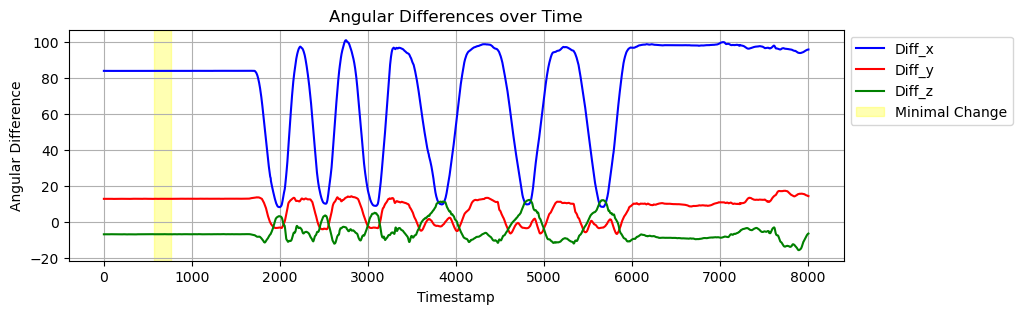

In [136]:
# Set the window size
window_size = 200

# Calculate the rolling standard deviation for each column
# rolling_std_x = baseline['Diff_x'].rolling(window=window_size).std()
rolling_std_y = flexion_baseline['Diff_y'].rolling(window=window_size).std()
rolling_std_z = flexion_baseline['Diff_z'].rolling(window=window_size).std()

# Find the intersection of minimal change sections
# minimal_change_section = (rolling_std_x + rolling_std_y + rolling_std_z).idxmin()
minimal_change_section = (rolling_std_y + rolling_std_z).idxmin()
# Extract the section
minimal_change_window_x = flexion_baseline.loc[minimal_change_section - window_size + 1:minimal_change_section]

# Plotting baseline['Diff_x'], baseline['Diff_y'], and baseline['Diff_z'] along with the section with minimal change

plt.figure(figsize=(10, 3))

# Plotting baseline['Diff_x']
plt.plot(flexion_baseline['timestamp'], flexion_baseline['Diff_x'], color='blue', label='Diff_x')

# Plotting baseline['Diff_y']
plt.plot(flexion_baseline['timestamp'], flexion_baseline['Diff_y'], color='red', label='Diff_y')

# Plotting baseline['Diff_z']
plt.plot(flexion_baseline['timestamp'], flexion_baseline['Diff_z'], color='green', label='Diff_z')

# Highlighting the section with minimal change
plt.axvspan(minimal_change_window_x['timestamp'].iloc[0], minimal_change_window_x['timestamp'].iloc[-1], color='yellow', alpha=0.3, label='Minimal Change')

plt.title('Angular Differences over Time')
plt.xlabel('Timestamp')
plt.ylabel('Angular Difference')
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.grid(True)
plt.show()




# # plot baseline 'Diff_x', 'Diff_y', 'Diff_z'
# plt.figure()
# baseline['Diff_x'].plot()
# baseline['Diff_y'].plot()
# baseline['Diff_z'].plot()

# plt.legend()
# plt.title('Angular difference')
# plt.show()